**Main mission in this competition** : Predicting sales for each product family and store combinations.

There are 6 data that we will study on them step by step.

* Train
* Test
* Store
* Transactions
* Holidays and Events
* Daily Oil Price

**Additional notes given to catch some abnormalities or patterns** :
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# Let's Start!
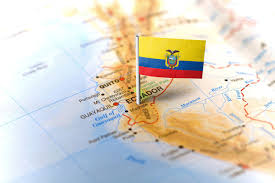

# 1. Importig Libraries

In [1]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 9.8 MB/s eta 0:00:00


In [2]:
# BASE
import numpy as np
import pandas as pd
import os
import calendar

# DATA VISUALIZATION
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as ticker

# MACHINE LEARNING
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from feature_engine.encoding import OrdinalEncoder
from feature_engine.creation import CyclicalFeatures
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

from xgboost import XGBRegressor
from tqdm.auto import tqdm

# 2. Importing Data

In [3]:
# Import
train = pd.read_csv("../input/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("../input/store-sales-time-series-forecasting/test.csv")
stores = pd.read_csv("../input/store-sales-time-series-forecasting/stores.csv")
sub = pd.read_csv("../input/store-sales-time-series-forecasting/sample_submission.csv")
transactions = pd.read_csv("../input/store-sales-time-series-forecasting/transactions.csv").sort_values(["store_nbr", "date"])
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
holidays = pd.read_csv("../input/store-sales-time-series-forecasting/holidays_events.csv")

In [4]:
# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)
oil["date"] = pd.to_datetime(oil.date)
holidays["date"] = pd.to_datetime(holidays.date)

In [5]:
# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")


In [6]:
test.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [7]:
print(f'Number of data_oil samples: {oil.shape}')
print(f'Number of train_data samples: {train.shape}')
print(f'Number of test_data samples: {test.shape}')
print(f'Number of data_holi samples: {holidays.shape}')
print(f'Number of data_store samples: {stores.shape}')
print(f'Number of data_trans samples: {transactions.shape}')

Number of data_oil samples: (1218, 2)
Number of train_data samples: (3000888, 6)
Number of test_data samples: (28512, 5)
Number of data_holi samples: (350, 6)
Number of data_store samples: (54, 5)
Number of data_trans samples: (83488, 3)


In [8]:
fig=go.Figure()
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3],
    y=[1.6, 1.6, 1.6, 1.6],
    mode="text", 
    text=["<span style='font-size:33px'><b>54</b></span>", 
          "<span style='font-size:33px'><b>33</b></span>",
          "<span style='font-size:33px'><b>16</b></span>",
          "<span style='font-size:33px'><b>56</b></span>"],
    textposition="bottom center"
))
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3],
    y=[1.1, 1.1, 1.1, 1.1],
    mode="text", 
    text=["Stores", "Products", "States", "Months"],
    textposition="bottom center"
))
fig.add_hline(y=2.2, line_width=5, line_color='gray')
fig.add_hline(y=0.3, line_width=3, line_color='gray')
fig.update_yaxes(visible=False)
fig.update_xaxes(visible=False)
fig.update_layout(showlegend=False, height=300, width=700, 
                  title='Store Sales Summary', title_x=0.5, title_y=0.9,
                  xaxis_range=[-0.5,3.6], yaxis_range=[-0.2,2.2],
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  font=dict(size=23, color='#323232'),
                  title_font=dict(size=35, color='#222'),
                  margin=dict(t=90,l=70,b=0,r=70), 
    )

# 3. Train

In [9]:
train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1   1 2013-01-01          1   BABY CARE    0.0          0.0
2   2 2013-01-01          1      BEAUTY    0.0          0.0
3   3 2013-01-01          1   BEVERAGES    0.0          0.0
4   4 2013-01-01          1       BOOKS    0.0          0.0

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float32       
 5   onpromotion  float16       
dtypes: datetime64[ns](1), float16(1), float32(1), int64(2), object(1)
memory usage: 108.8+ MB


In [11]:
train.describe()

id     store_nbr         sales  onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06    3000888.0
mean   1.500444e+06  2.750000e+01  3.577758e+02          NaN
std    8.662819e+05  1.558579e+01  1.101998e+03          NaN
min    0.000000e+00  1.000000e+00  0.000000e+00          0.0
25%    7.502218e+05  1.400000e+01  0.000000e+00          0.0
50%    1.500444e+06  2.750000e+01  1.100000e+01          0.0
75%    2.250665e+06  4.100000e+01  1.958473e+02          0.0
max    3.000887e+06  5.400000e+01  1.247170e+05        741.0

In [12]:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [13]:
print(train.family.unique())
print(len(train.family.unique()))
train['family'] = train['family'].astype('category')
train['family_category'] = train['family'].cat.codes

family_category = dict( zip( train['family'].cat.codes, train['family'] ) )
family_category

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
33


{0: 'AUTOMOTIVE',
 1: 'BABY CARE',
 2: 'BEAUTY',
 3: 'BEVERAGES',
 4: 'BOOKS',
 5: 'BREAD/BAKERY',
 6: 'CELEBRATION',
 7: 'CLEANING',
 8: 'DAIRY',
 9: 'DELI',
 10: 'EGGS',
 11: 'FROZEN FOODS',
 12: 'GROCERY I',
 13: 'GROCERY II',
 14: 'HARDWARE',
 15: 'HOME AND KITCHEN I',
 16: 'HOME AND KITCHEN II',
 17: 'HOME APPLIANCES',
 18: 'HOME CARE',
 19: 'LADIESWEAR',
 20: 'LAWN AND GARDEN',
 21: 'LINGERIE',
 22: 'LIQUOR,WINE,BEER',
 23: 'MAGAZINES',
 24: 'MEATS',
 25: 'PERSONAL CARE',
 26: 'PET SUPPLIES',
 27: 'PLAYERS AND ELECTRONICS',
 28: 'POULTRY',
 29: 'PREPARED FOODS',
 30: 'PRODUCE',
 31: 'SCHOOL AND OFFICE SUPPLIES',
 32: 'SEAFOOD'}

In [14]:
train['family'].value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

In [15]:
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

In [16]:
train.head()

id       date  store_nbr      family  sales  onpromotion  family_category  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0          0.0                0   
1   1 2013-01-01          1   BABY CARE    0.0          0.0                1   
2   2 2013-01-01          1      BEAUTY    0.0          0.0                2   
3   3 2013-01-01          1   BEVERAGES    0.0          0.0                3   
4   4 2013-01-01          1       BOOKS    0.0          0.0                4   

   day_of_week  month  year  
0            1      1  2013  
1            1      1  2013  
2            1      1  2013  
3            1      1  2013  
4            1      1  2013

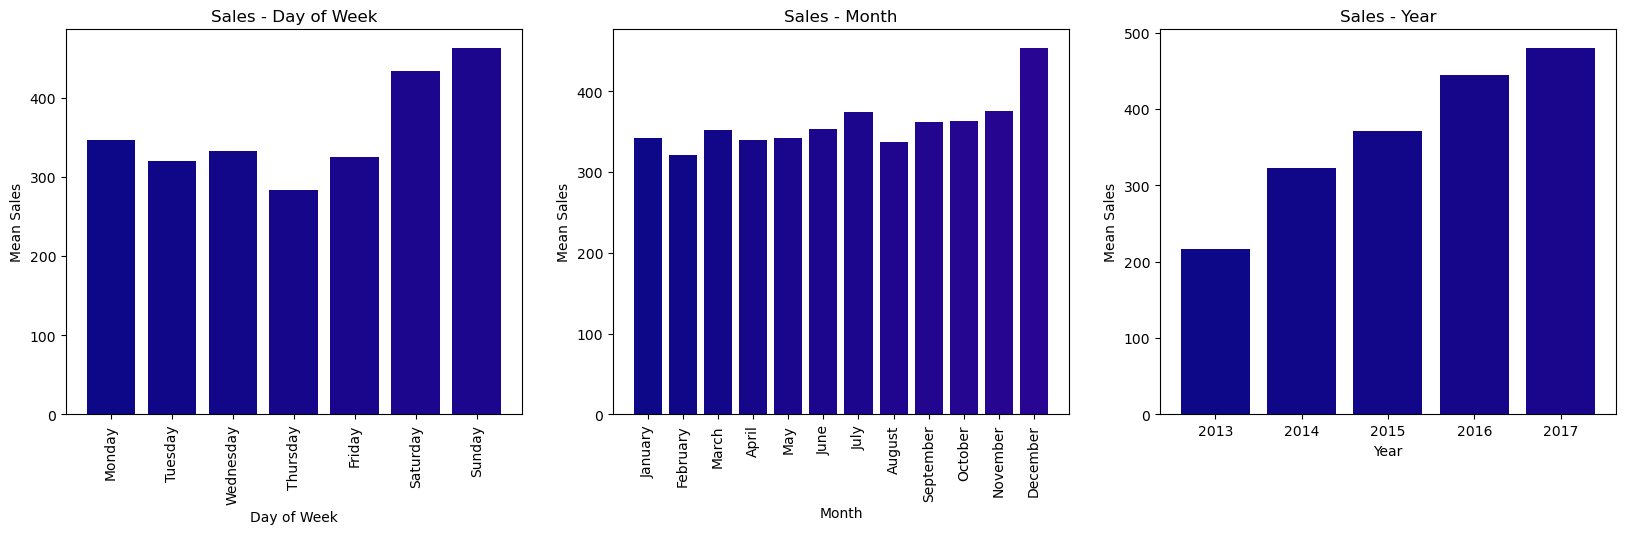

In [17]:
data_grouped_day = train.groupby(['day_of_week']).mean()['sales']
data_grouped_month = train.groupby(['month']).mean()['sales']
data_grouped_year = train.groupby(['year']).mean()['sales']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Day of Week subplot
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
bars1 = axs[0].bar(day_names, data_grouped_day, color=plt.cm.plasma(np.arange(len(data_grouped_day))))
axs[0].set_title('Sales - Day of Week')
axs[0].set_xlabel('Day of Week')
axs[0].set_ylabel('Mean Sales')
axs[0].tick_params(axis='x', rotation=90)

# Month subplot
month_names = [calendar.month_name[i] for i in range(1, 13)]
bars2 = axs[1].bar(month_names, data_grouped_month, color=plt.cm.plasma(np.arange(len(data_grouped_month))))
axs[1].set_title('Sales - Month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Mean Sales')
axs[1].tick_params(axis='x', rotation=90)

# Year subplot
bars3 = axs[2].bar(data_grouped_year.index, data_grouped_year, color=plt.cm.plasma(np.arange(len(data_grouped_year))))
axs[2].set_title('Sales - Year')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Mean Sales')

plt.show()

* ### Most sales in week - Saturday and Sunday
* ### Most sales in month - December
* ### sales in year - Increasing yearly

# 4. Transactions

In [18]:
transactions.head()

date  store_nbr  transactions
1   2013-01-02          1          2111
47  2013-01-03          1          1833
93  2013-01-04          1          1863
139 2013-01-05          1          1509
185 2013-01-06          1           520

In [19]:
transactions['store_nbr'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

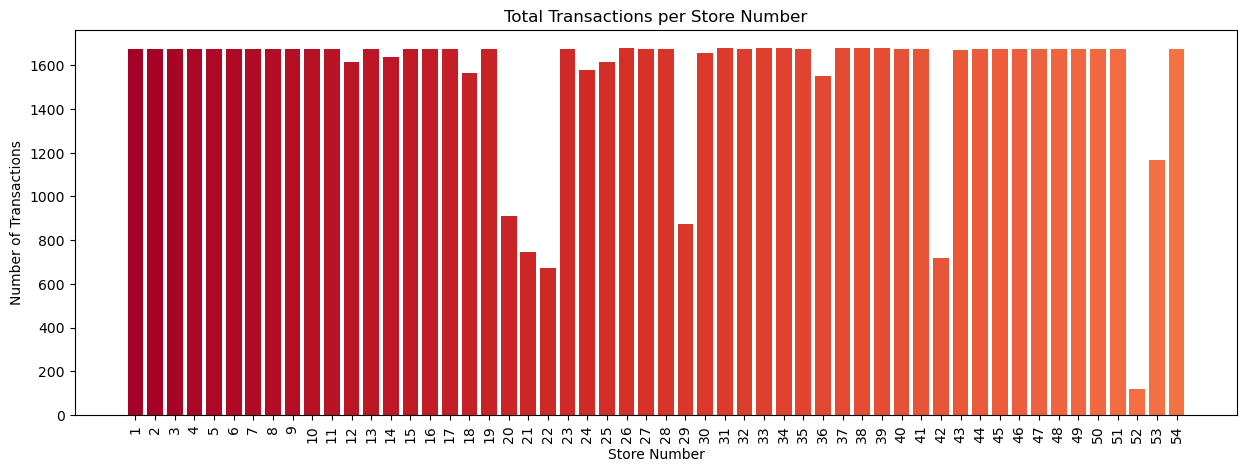

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
store_counts = transactions['store_nbr'].value_counts().sort_index()
bars = axes.bar(store_counts.index, store_counts.values, color=plt.cm.RdYlBu(np.arange(len(store_counts))))

axes.set_xlabel("Store Number")
axes.set_ylabel("Number of Transactions")
axes.set_title("Total Transactions per Store Number")

# set the xticks and rotate the labels
plt.xticks(store_counts.index, rotation='vertical')

plt.show()

In [21]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83488 entries, 1 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.5 MB


In [22]:
transactions.describe()

store_nbr  transactions
count  83488.000000  83488.000000
mean      26.939237   1694.602158
std       15.608204    963.286644
min        1.000000      5.000000
25%       13.000000   1046.000000
50%       27.000000   1393.000000
75%       40.000000   2079.000000
max       54.000000   8359.000000

In [23]:
transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [24]:
transactions['day_of_week'] = transactions['date'].dt.dayofweek
transactions['month'] = transactions['date'].dt.month
transactions['year'] = transactions['date'].dt.year

In [25]:
transactions.head()

date  store_nbr  transactions  day_of_week  month  year
1   2013-01-02          1          2111            2      1  2013
47  2013-01-03          1          1833            3      1  2013
93  2013-01-04          1          1863            4      1  2013
139 2013-01-05          1          1509            5      1  2013
185 2013-01-06          1           520            6      1  2013

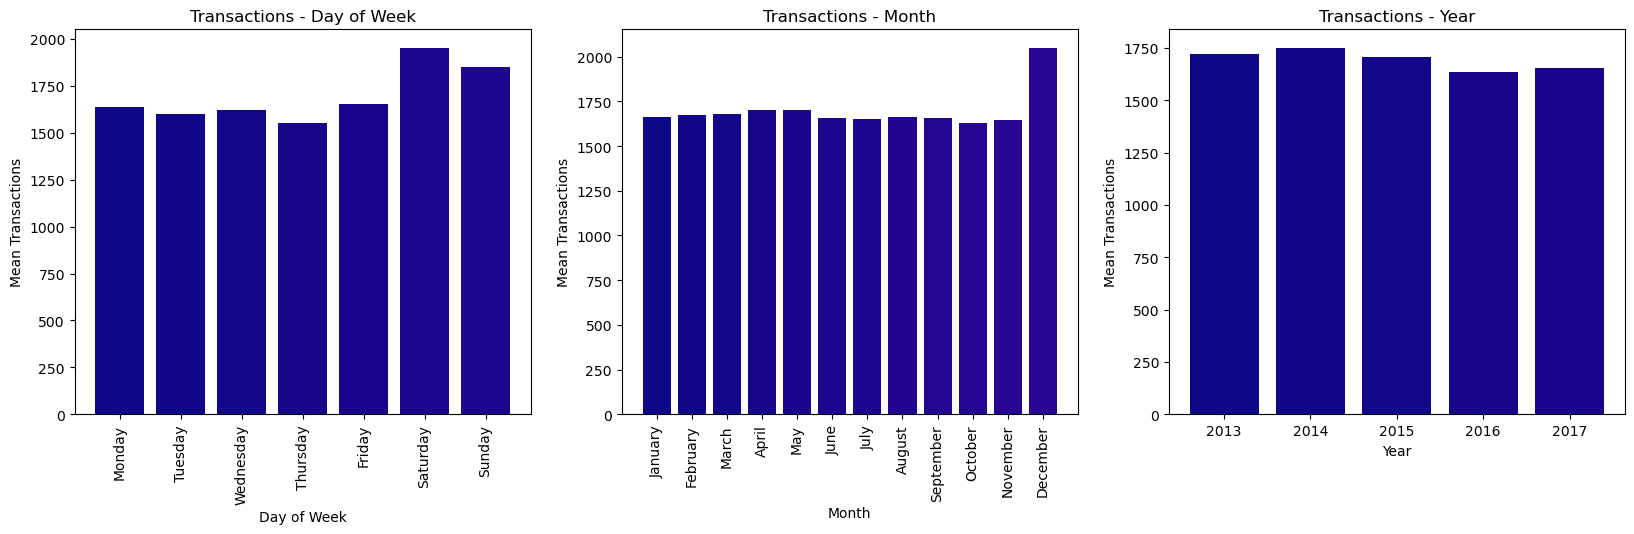

In [26]:
data_grouped_day = transactions.groupby(['day_of_week']).mean()['transactions']
data_grouped_month = transactions.groupby(['month']).mean()['transactions']
data_grouped_year = transactions.groupby(['year']).mean()['transactions']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Day of Week subplot
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
bars1 = axs[0].bar(day_names, data_grouped_day, color=plt.cm.plasma(np.arange(len(data_grouped_day))))
axs[0].set_title('Transactions - Day of Week')
axs[0].set_xlabel('Day of Week')
axs[0].set_ylabel('Mean Transactions')
axs[0].tick_params(axis='x', rotation=90)

# Month subplot
month_names = [calendar.month_name[i] for i in range(1, 13)]
bars2 = axs[1].bar(month_names, data_grouped_month, color=plt.cm.plasma(np.arange(len(data_grouped_month))))
axs[1].set_title('Transactions - Month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Mean Transactions')
axs[1].tick_params(axis='x', rotation=90)

# Year subplot
bars3 = axs[2].bar(data_grouped_year.index, data_grouped_year, color=plt.cm.plasma(np.arange(len(data_grouped_year))))
axs[2].set_title('Transactions - Year')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Mean Transactions')

plt.show()

* ### Most transactions in week - Saturday and Sunday
* ### Most transactions in month - December
* ### Transactions in year - Remaining almost at same level

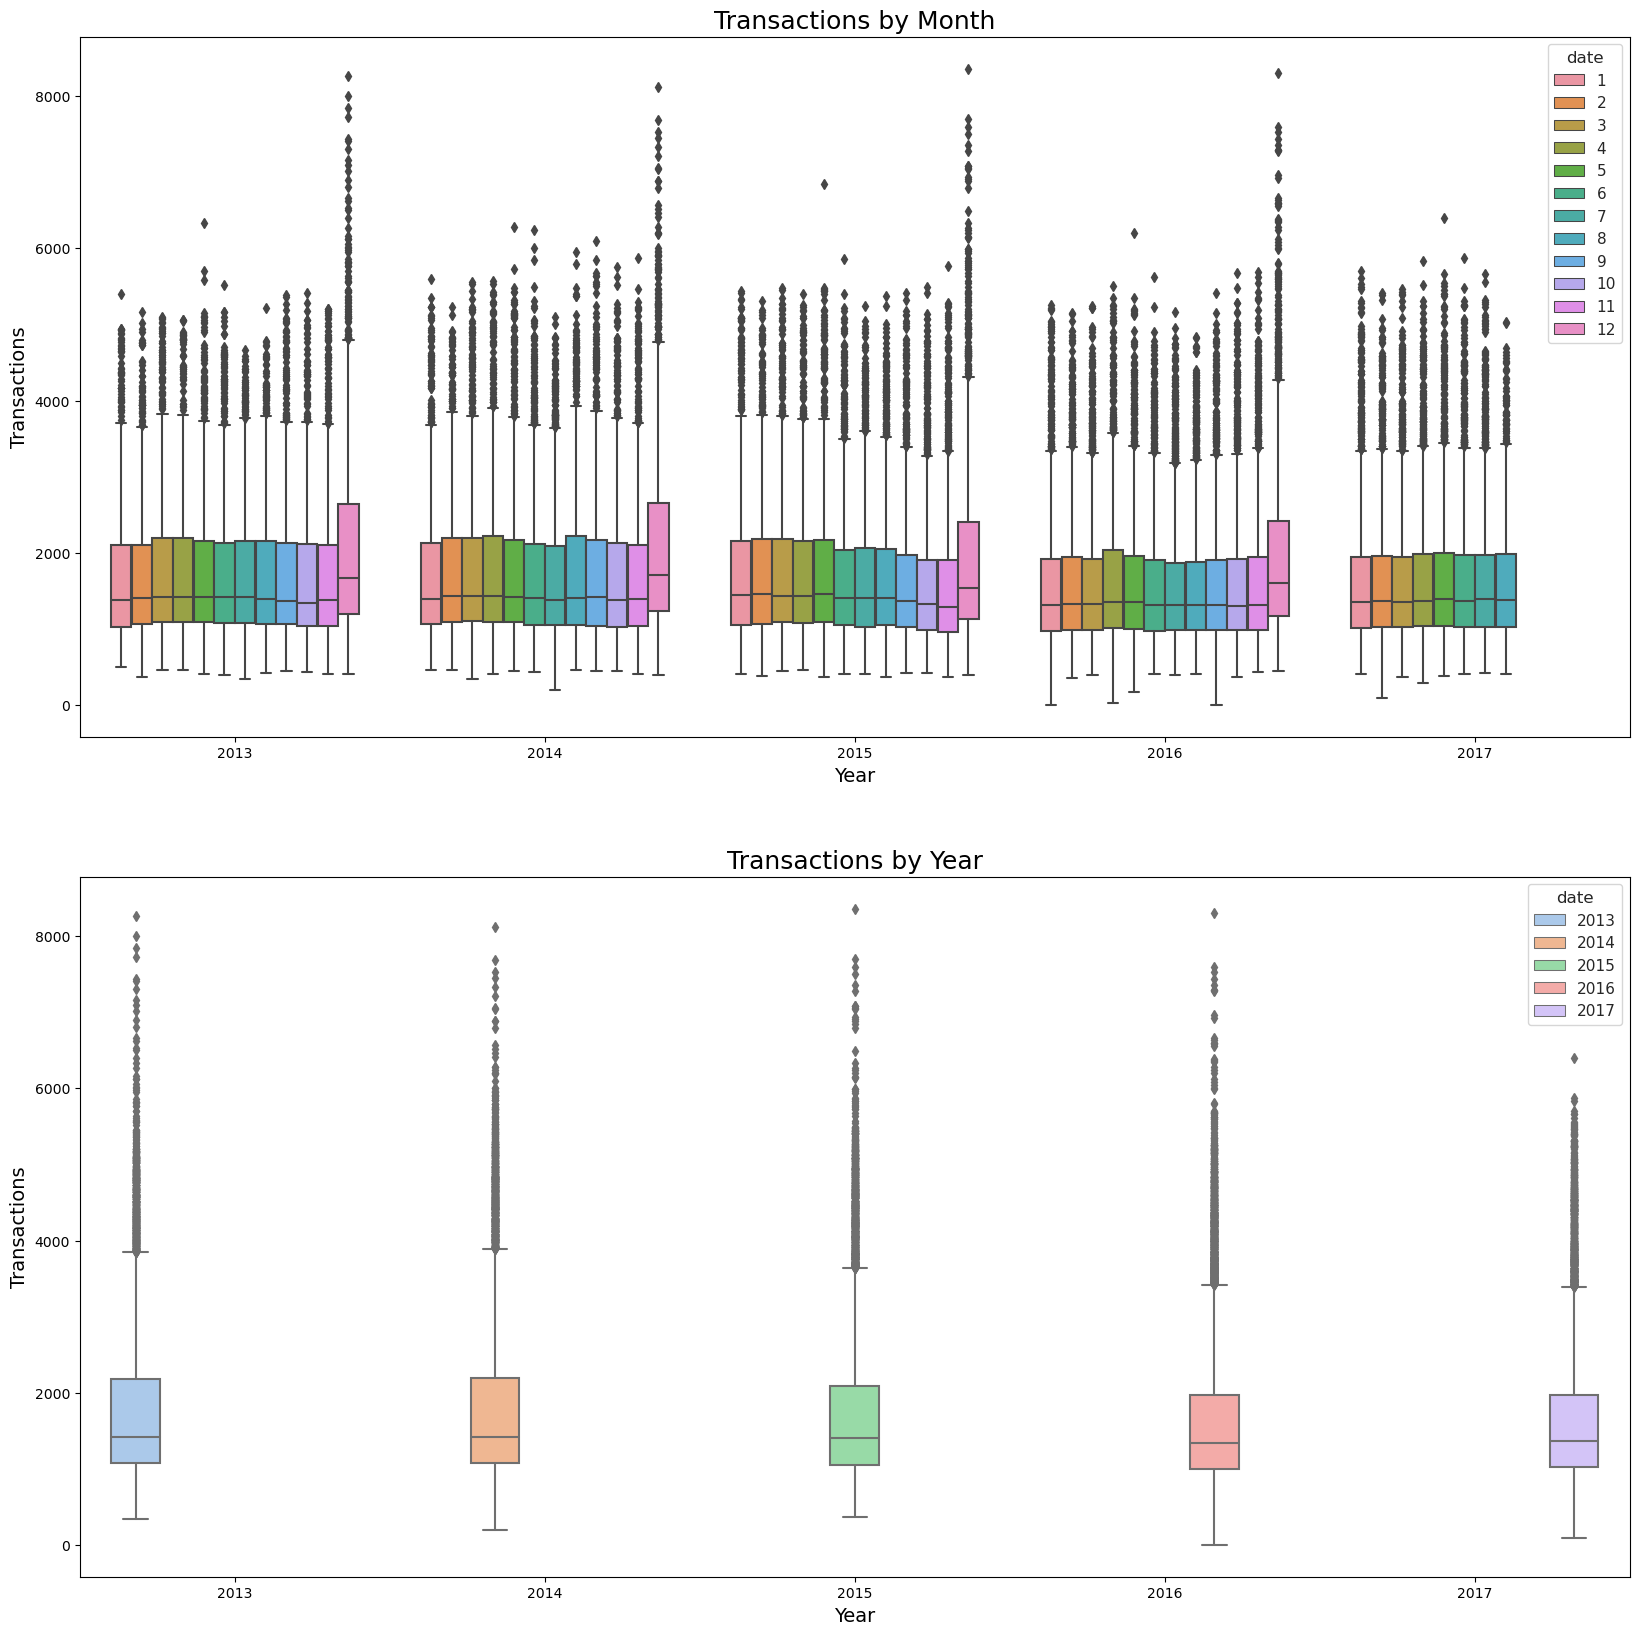

In [27]:
def plot_boxplot(palette, x, y, hue, ax, title):
    sns.set_theme(style="ticks", palette=palette)
    ax = sns.boxplot(x=x, y=y, hue=hue, ax=ax)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Year' if hue.name == x.name else 'Month', fontsize=14)
    ax.set_ylabel('Transactions', fontsize=14)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,20))
sns.set(font_scale=1.5)

plot_boxplot("pastel", transactions['date'].dt.year, transactions['transactions'], transactions['date'].dt.month, axes[0], "Transactions by Month")
plot_boxplot("pastel", transactions['date'].dt.year, transactions['transactions'], transactions['date'].dt.year, axes[1], "Transactions by Year")

plt.show()

# 5. Oil Prices

In [28]:
oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

In [29]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [30]:
oil.describe()

dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000

In [31]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

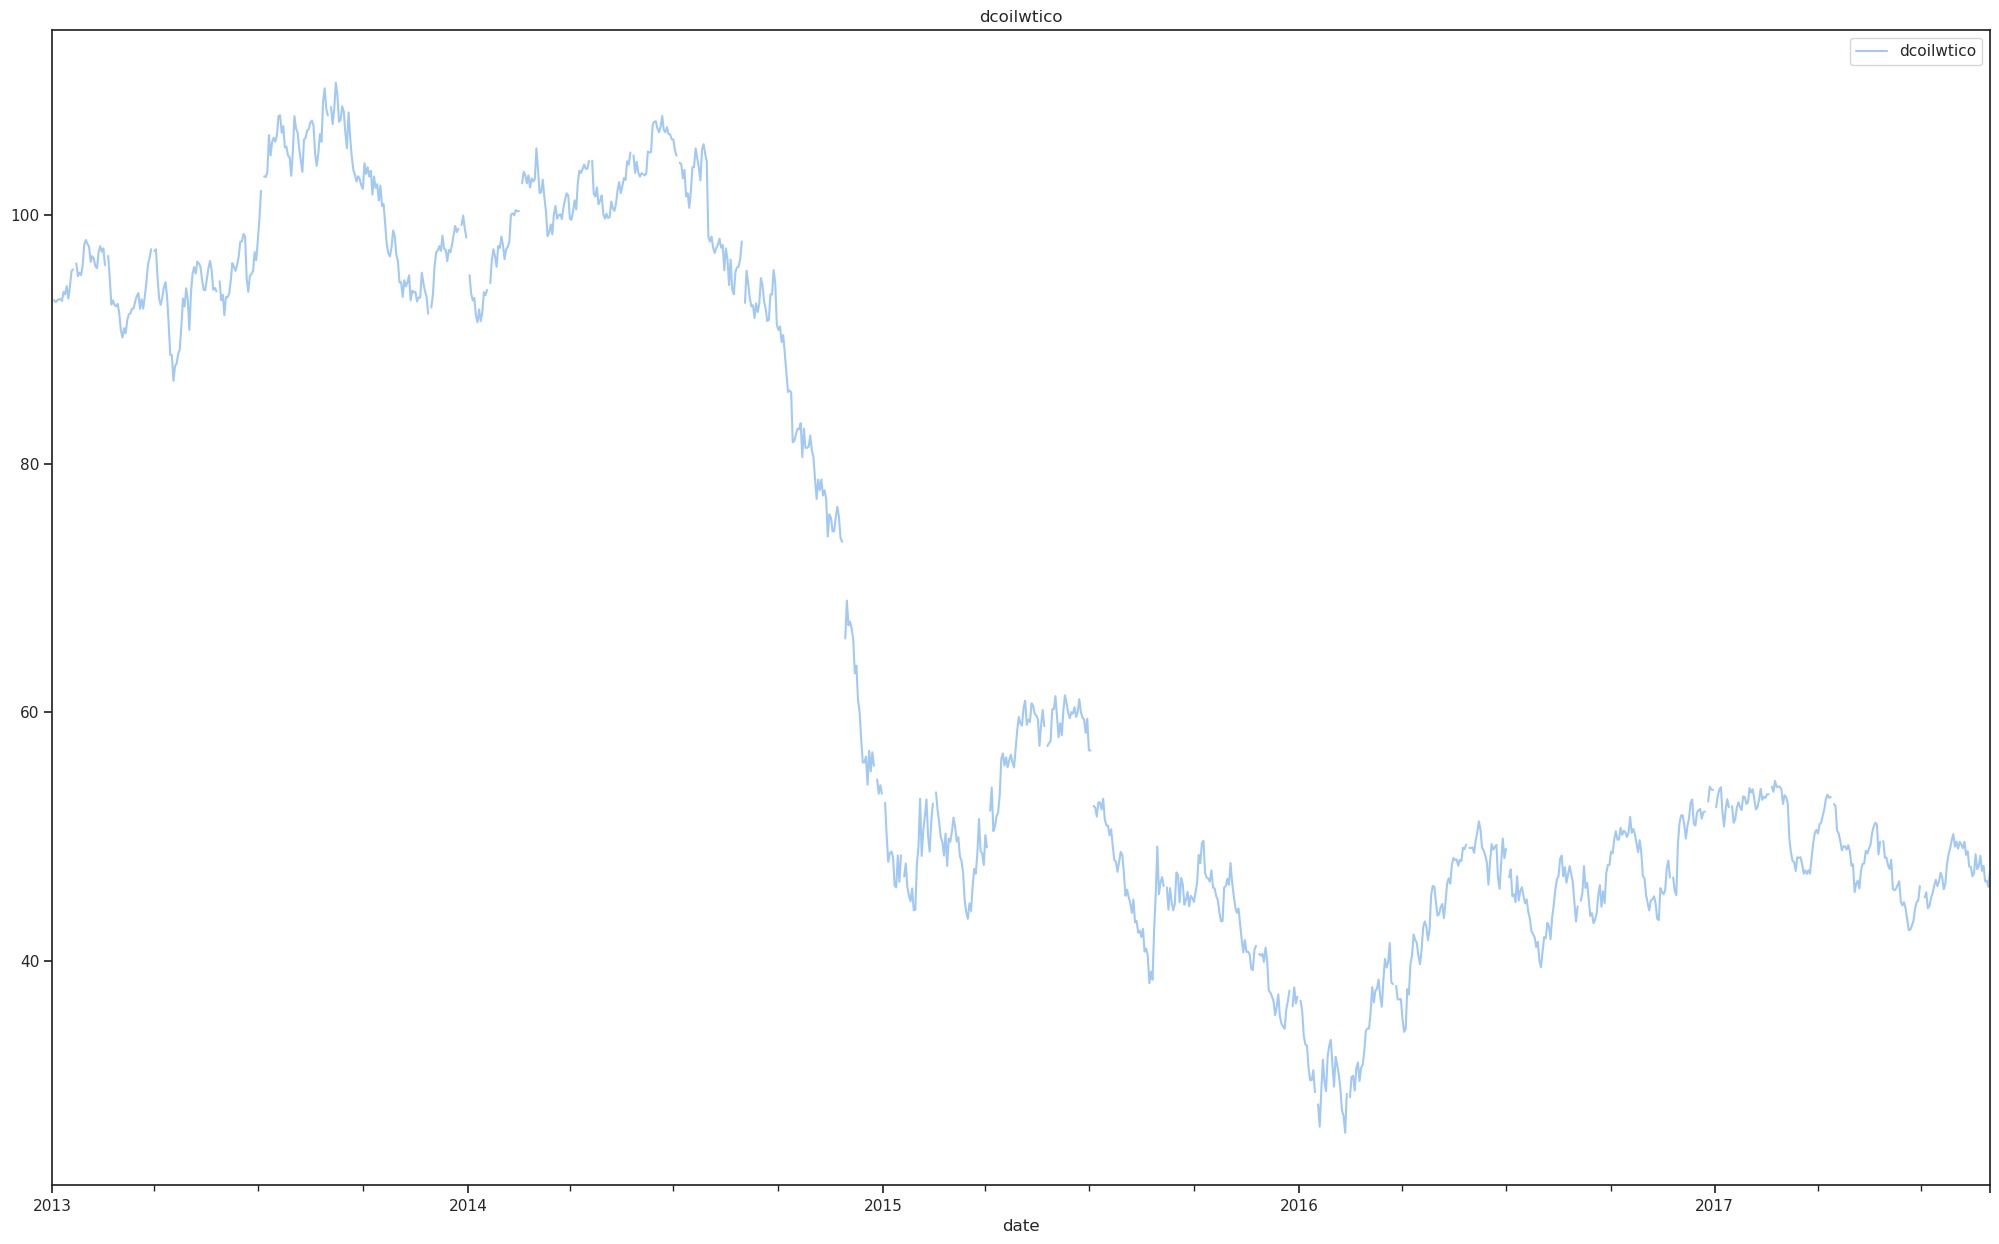

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
oil.plot.line(x="date", y="dcoilwtico", color='b', title ="dcoilwtico", ax = axes)
plt.show()

### Oil prices were highest in later half of 2013 but started decreasing from 2014 and reached its lowest value in 2016. Continued to rise to remain in the price range of 40 to 60 dollars.

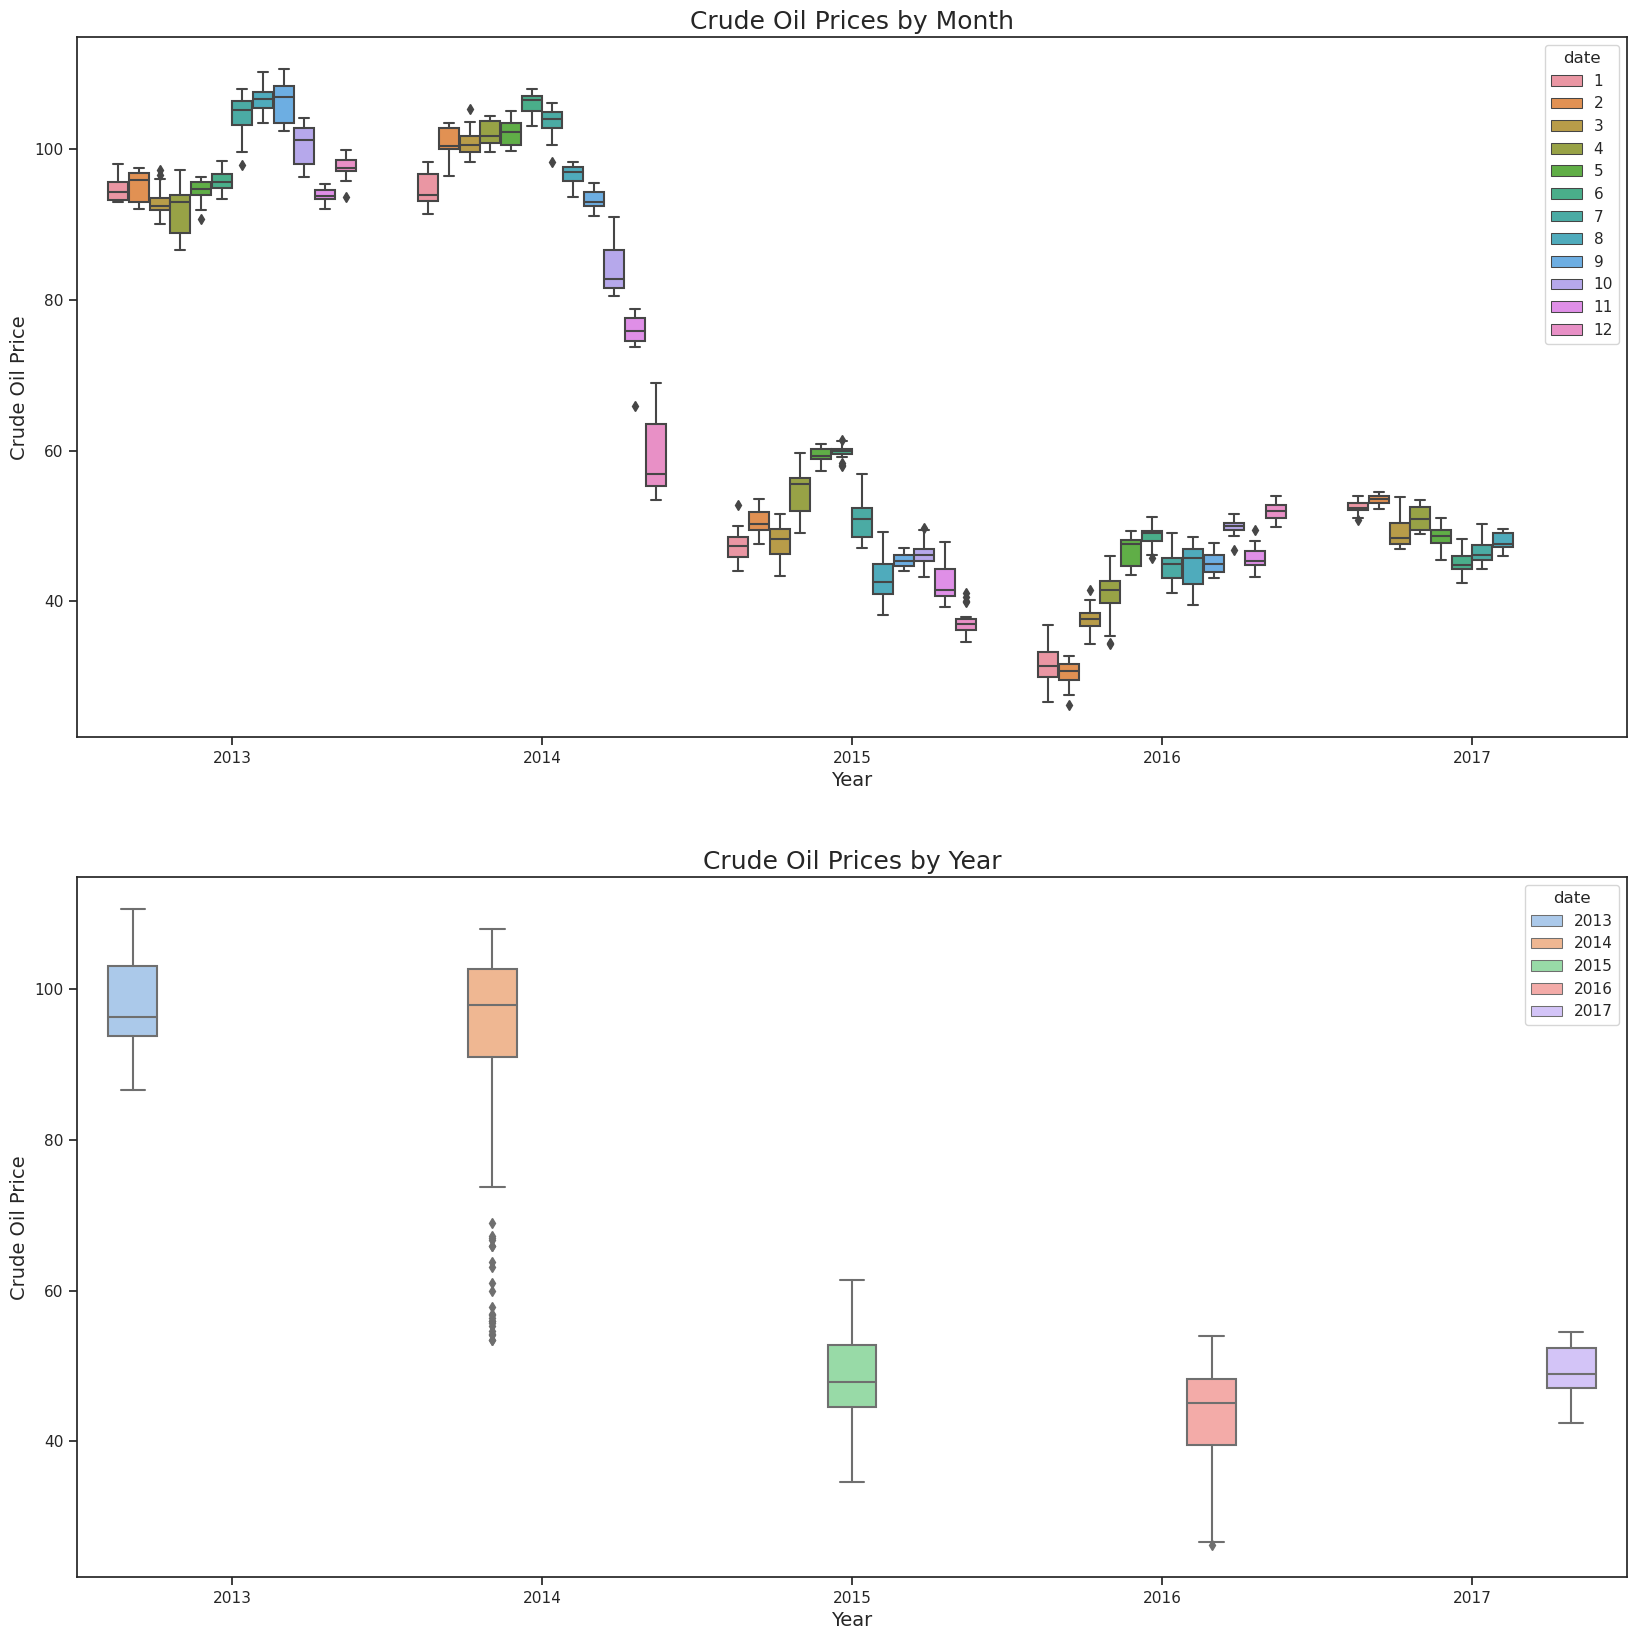

In [33]:
def plot_boxplot(palette, x, y, hue, ax, title):
    sns.set_theme(style="ticks", palette=palette)
    ax = sns.boxplot(x=x, y=y, hue=hue, ax=ax)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Year' if hue.name == x.name else 'Month', fontsize=14)
    ax.set_ylabel('Crude Oil Price', fontsize=14)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,20))
sns.set(font_scale=1.5)

plot_boxplot("pastel", oil['date'].dt.year, oil['dcoilwtico'], oil['date'].dt.month, axes[0], "Crude Oil Prices by Month")
plot_boxplot("pastel", oil['date'].dt.year, oil['dcoilwtico'], oil['date'].dt.year, axes[1], "Crude Oil Prices by Year")

plt.show()

# 6. Stores

In [34]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [35]:
stores['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [36]:
stores['city'].unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [37]:
stores['state'].unique()


array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [38]:
stores['cluster'].unique()

array([13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17],
      dtype=int8)

In [39]:
stores['cluster'].value_counts()

3     7
6     6
10    6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: cluster, dtype: int64

In [40]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int8  
dtypes: int64(1), int8(1), object(3)
memory usage: 1.9+ KB


In [41]:
stores.describe()

store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000

In [42]:
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

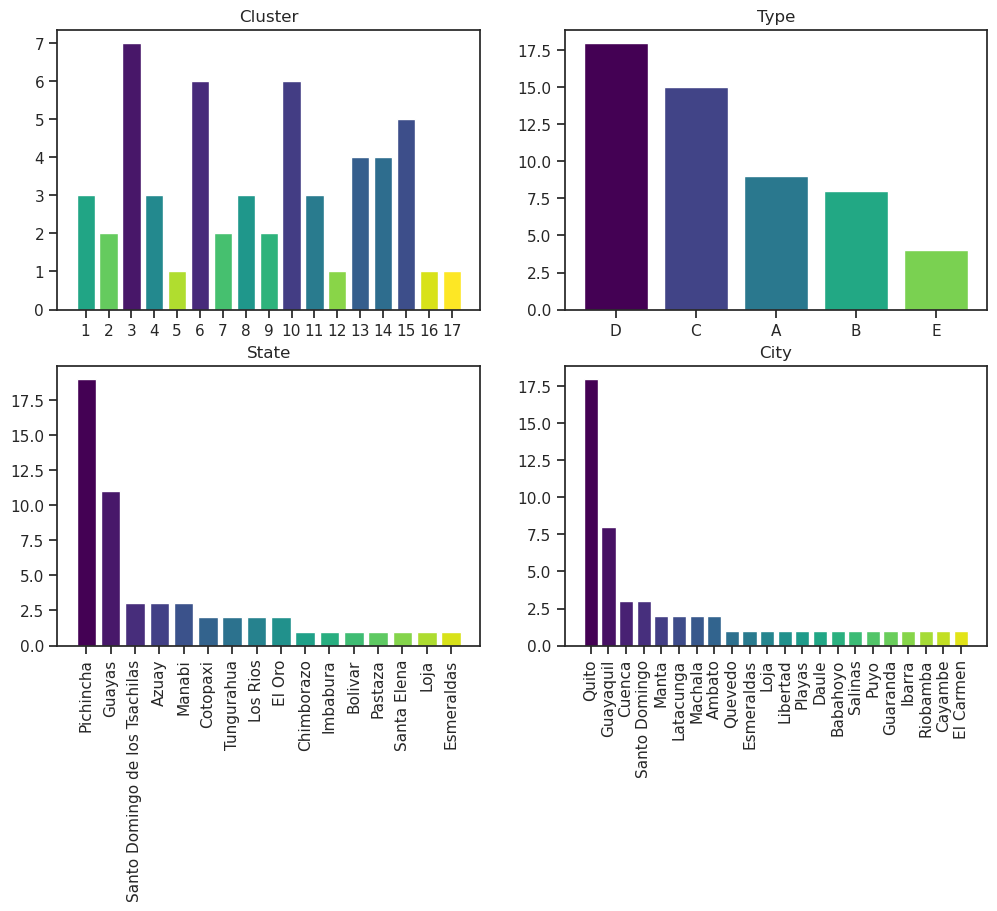

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

clusters = np.arange(1, len(stores['cluster'].unique())+1)

axs[0, 0].bar(stores['cluster'].value_counts().index, stores['cluster'].value_counts(), color=plt.cm.viridis(clusters / len(clusters)))
axs[0, 0].set_title('Cluster')
axs[0, 0].set_xticks(clusters)

axs[0, 1].bar(stores['type'].value_counts().index, stores['type'].value_counts(), color=plt.cm.viridis(np.arange(len(stores['type'].value_counts().index))/len(stores['type'].value_counts().index)))
axs[0, 1].set_title('Type')

axs[1, 0].bar(stores['state'].value_counts().index, stores['state'].value_counts(), color=plt.cm.viridis(np.arange(len(stores['state'].value_counts().index))/len(stores['state'].value_counts().index)))
axs[1, 0].set_title('State')
axs[1, 0].set_xticks(np.arange(len(stores['state'].value_counts().index)))
axs[1, 0].set_xticklabels(stores['state'].value_counts().index, rotation=90)

axs[1, 1].bar(stores['city'].value_counts().index, stores['city'].value_counts(), color=plt.cm.viridis(np.arange(len(stores['city'].value_counts().index))/len(stores['city'].value_counts().index)))
axs[1, 1].set_title('City')
axs[1, 1].set_xticks(np.arange(len(stores['city'].value_counts().index)))
axs[1, 1].set_xticklabels(stores['city'].value_counts().index, rotation=90)

plt.show()

# 7. Holidays

In [44]:
holidays.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [45]:
holidays['locale_name'].unique()

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

In [46]:
holidays['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [47]:
holidays['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [48]:
holidays['type'].value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [49]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [50]:
holidays.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Average holiday sales is 425.4221496582031


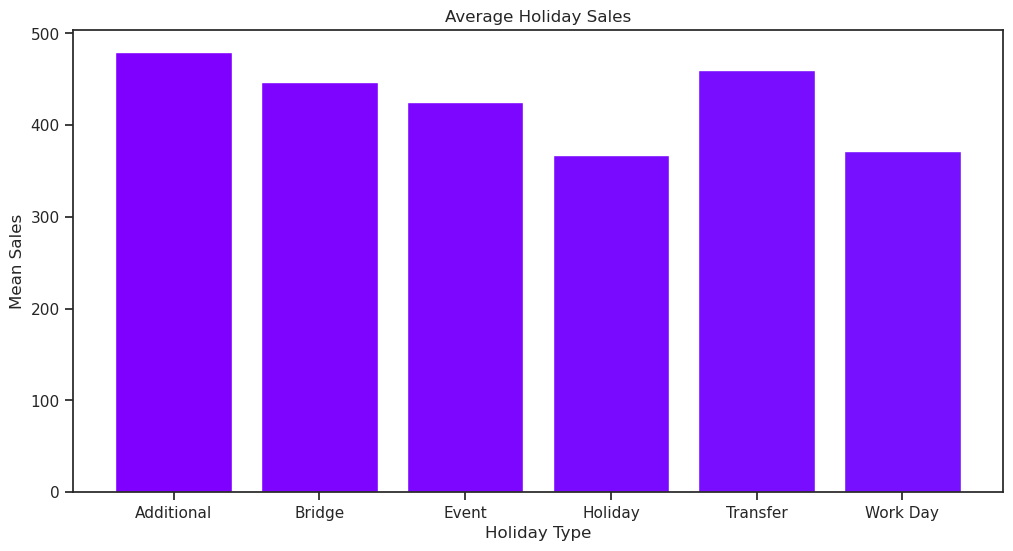

In [51]:
day_type = holidays[['date', 'type']]
avg_sales = train.groupby('date').agg({'sales': 'mean'}).reset_index()

df = pd.merge_asof(day_type, avg_sales, on='date')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df_1 = df.groupby(['type']).mean()['sales']
average_holiday_sales = df_1.mean()

print(f'Average holiday sales is {average_holiday_sales}')

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(df_1.index, df_1, color=plt.cm.rainbow(np.arange(len(df_1))))

ax.set_title('Average Holiday Sales')
ax.set_xlabel('Holiday Type')
ax.set_ylabel('Mean Sales')

plt.show()

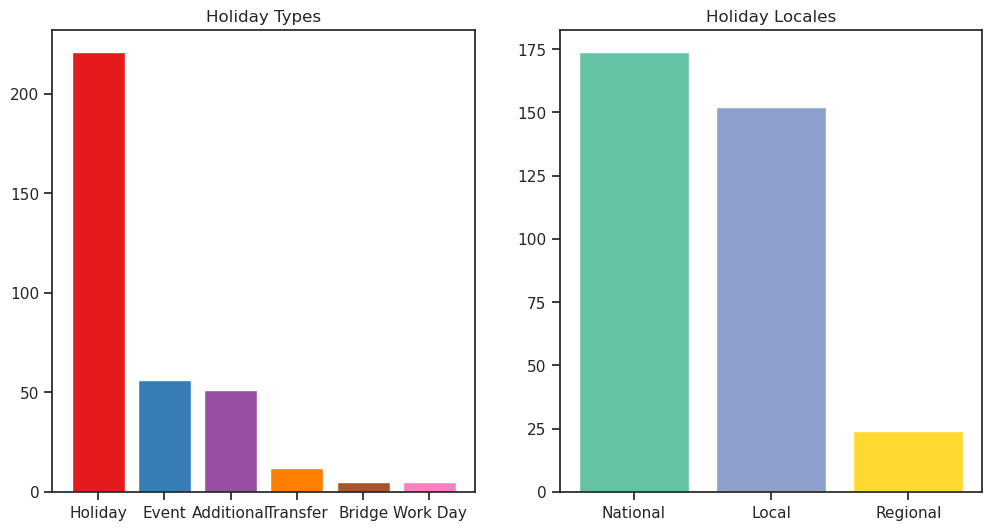

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].bar(holidays['type'].value_counts().index, holidays['type'].value_counts(), color=plt.cm.Set1(np.arange(len(holidays['type'].value_counts().index))/len(holidays['type'].value_counts().index)))
axs[0].set_title('Holiday Types')

axs[1].bar(holidays['locale'].value_counts().index, holidays['locale'].value_counts(), color=plt.cm.Set2(np.arange(len(holidays['locale'].value_counts().index))/len(holidays['locale'].value_counts().index)))
axs[1].set_title('Holiday Locales')

plt.show()

# 8. Visualizations

## Most sold items

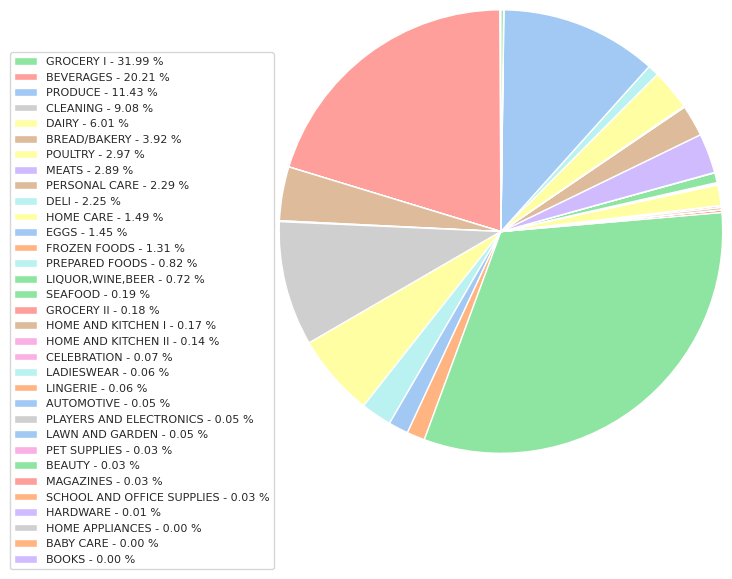

In [53]:
data_grouped_family_types = train.groupby(['family_category']).mean()[['sales', 'onpromotion']]


data_grouped_family_types['%_s'] = 100 * data_grouped_family_types['sales'] / data_grouped_family_types['sales'].sum()
data_grouped_family_types['%_s'] = data_grouped_family_types['%_s'].round(decimals = 3)


percent = 100 * data_grouped_family_types['sales'] / data_grouped_family_types['sales'].sum()
percent = percent.round(decimals = 3)
patches, texts = plt.pie(data_grouped_family_types['%_s'], startangle=90, radius=1.5)


lables_2 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(family_category.values(), percent)]


sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, lables_2, data_grouped_family_types['%_s']),
                                          key=lambda x: x[2],
                                          reverse=True))
    
plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

## On Promotion of items

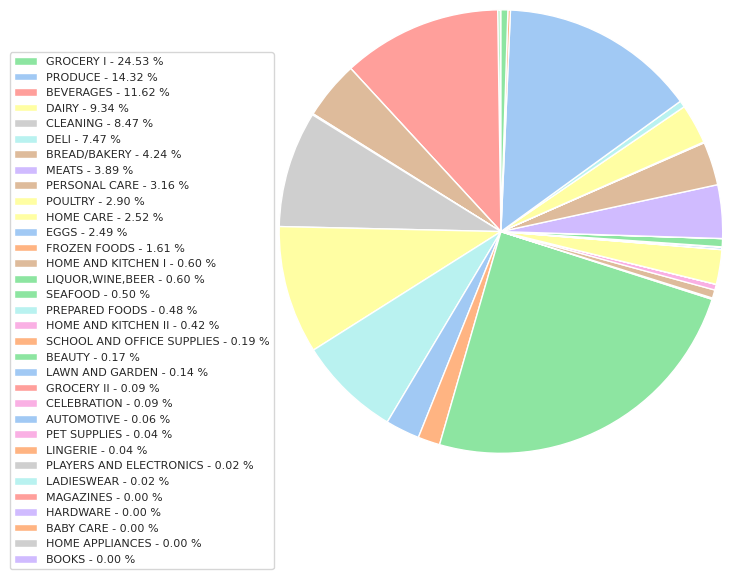

In [54]:
data_grouped_family_types = train.groupby(['family_category']).mean()[['sales', 'onpromotion']]


data_grouped_family_types['%_p'] = 100 * data_grouped_family_types['onpromotion'] / data_grouped_family_types['onpromotion'].sum()
data_grouped_family_types['%_p'] = data_grouped_family_types['%_p'].round(decimals = 3)


percent = 100 * data_grouped_family_types['onpromotion'] / data_grouped_family_types['onpromotion'].sum()
percent = percent.round(decimals = 3)
patches, texts = plt.pie(data_grouped_family_types['%_p'], startangle=90, radius=1.5)


lables_2 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(family_category.values(), percent)]


sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, lables_2, data_grouped_family_types['%_p']),
                                          key=lambda x: x[2],
                                          reverse=True))
    
plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

### We can see that most sold items and with most promotion are Grocery,Beverages,Produce,Dairy and Cleaning. Grocery + Beverage account for more than 50% of the sales

### Since our dataset contains a large number of rows, grouping the data, for instance, by week or month, will be simpler. Mean-based aggregation will be used.

In [55]:
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [56]:
df_grouped_trans_w = grouped(transactions, 'date', 'W', 'transactions')

### For better forecasting added time column

In [57]:
def add_time(df, key, freq, col):
    """ ADD COLUMN 'TIME' TO DF """
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

In [58]:
df_grouped_train_w = add_time(train, 'date', 'W', 'sales')
df_grouped_train_m = add_time(train, 'date', 'M', 'sales')

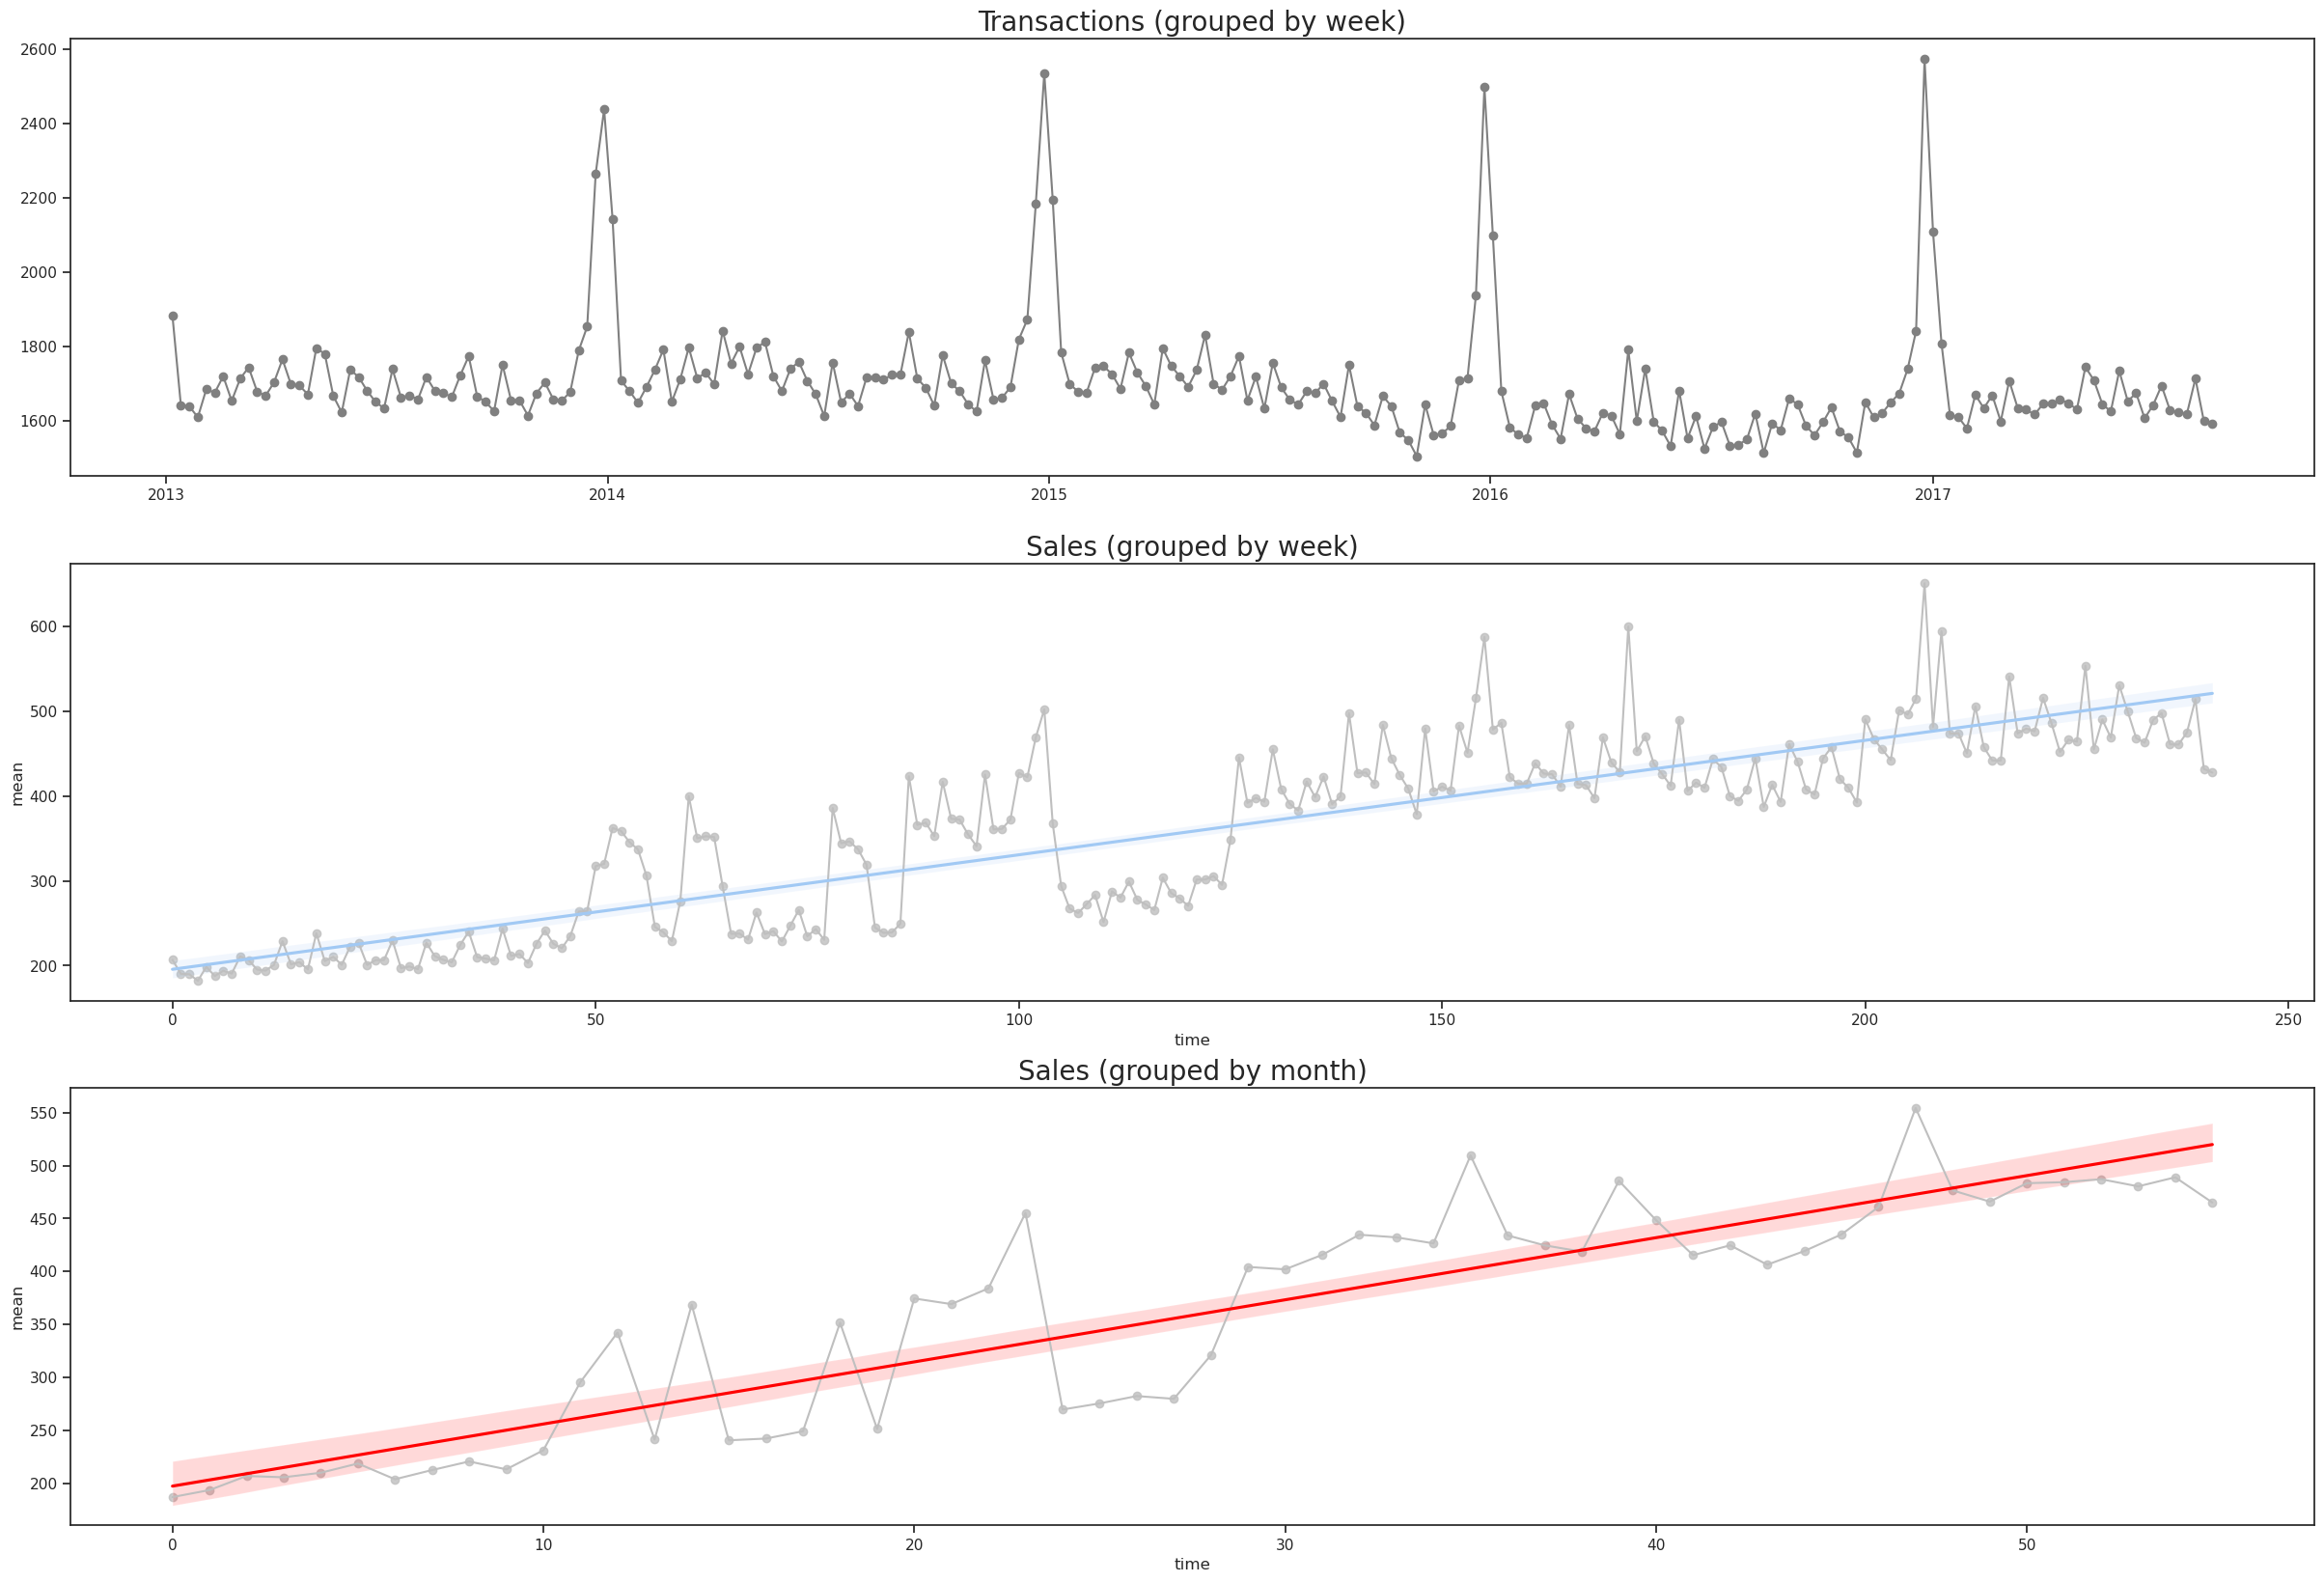

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30,20))

# TRANSACTIONS (WEEKLY)
axes[0].plot('date', 'mean', data=df_grouped_trans_w, color='grey', marker='o')
axes[0].set_title("Transactions (grouped by week)", fontsize=20)

# SALES (WEEKLY)
axes[1].plot('time', 'mean', data=df_grouped_train_w, color='0.75')
axes[1].set_title("Sales (grouped by week)", fontsize=20)
# linear regression
axes[1] = sns.regplot(x='time', 
                      y='mean', 
                      data=df_grouped_train_w, 
                      scatter_kws=dict(color='0.75'), 
                      ax = axes[1])

# SALES (MONTHLY)
axes[2].plot('time', 'mean', data=df_grouped_train_m, color='0.75')
axes[2].set_title("Sales (grouped by month)", fontsize=20)
# linear regression
axes[2] = sns.regplot(x='time', 
                      y='mean', 
                      data=df_grouped_train_m, 
                      scatter_kws=dict(color='0.75'), 
                      line_kws={"color": "red"},
                      ax = axes[2])

plt.show()

In [60]:
# Create copies of the data with date as the index
transactions_indexed = transactions.set_index('date').copy()
holidays_indexed = holidays.set_index('date').copy()
oil_indexed = oil.set_index('date').copy()
train_indexed = train.set_index('date').copy()

# 9. Trend

In [61]:
def plot_trend(data, column_name, frequency, data_name):

    if frequency == 'week':
        data_resampled = data[column_name].resample('W').sum()
    elif frequency == 'month':
        data_resampled = data[column_name].resample('M').sum()
    elif frequency == 'year':
        data_resampled = data[column_name].resample('Y').sum()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=data_resampled.index, y=data_resampled, color='blue')
    plt.xticks(rotation=90)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(data_name, fontsize=12)
    plt.title(f'{data_name} Trend ({frequency}-wise)', fontsize=14)
    
    formatter = ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x/1000000))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.show()


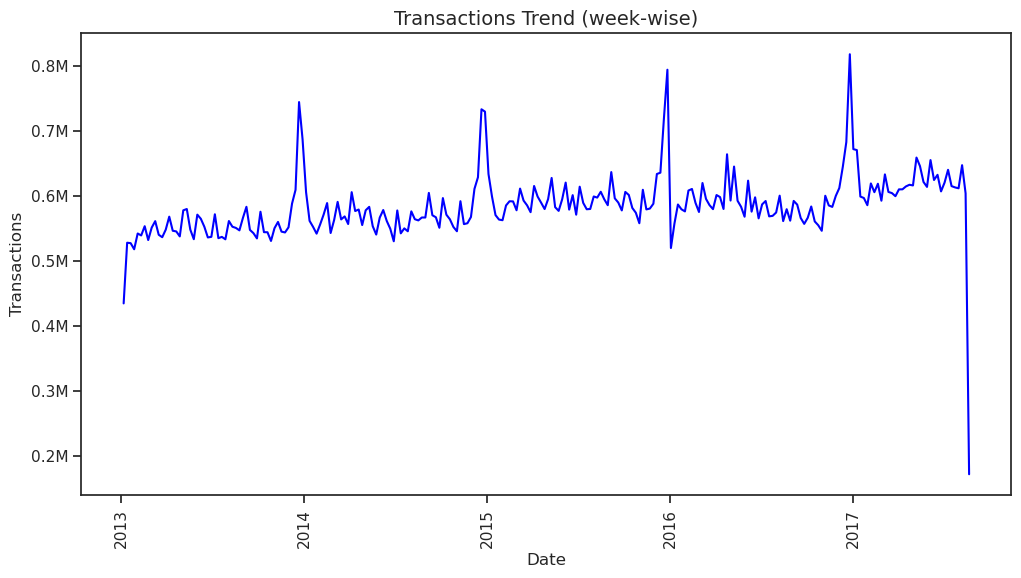

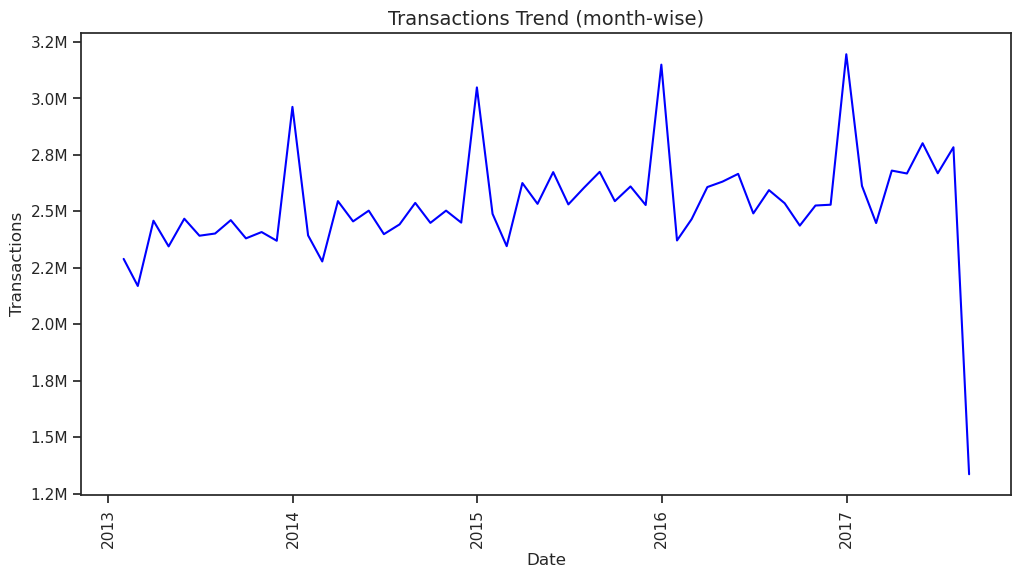

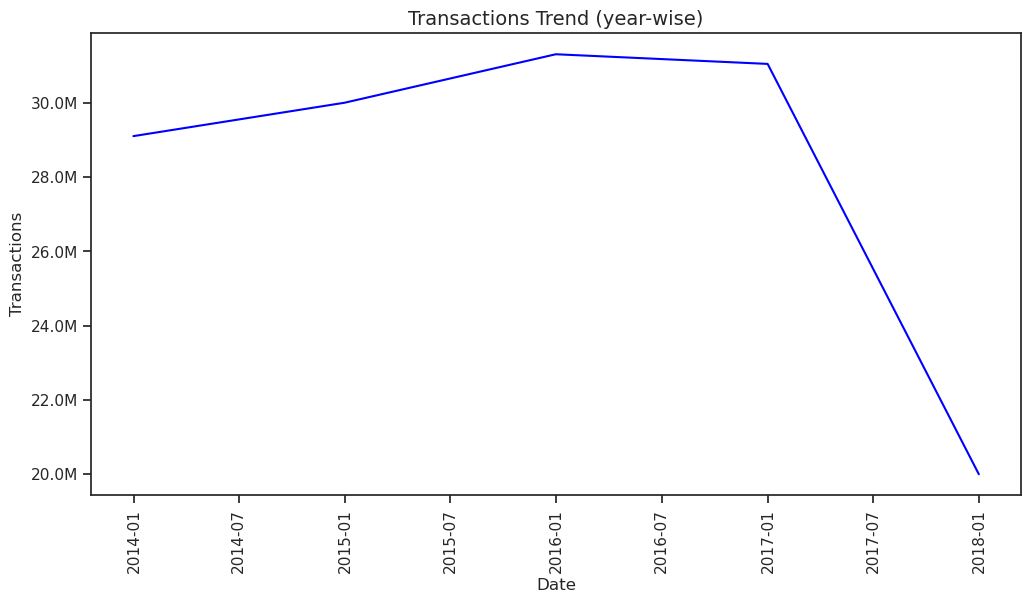

In [62]:
plot_trend(transactions_indexed, 'transactions', 'week', 'Transactions')
plot_trend(transactions_indexed, 'transactions', 'month', 'Transactions')
plot_trend(transactions_indexed, 'transactions', 'year', 'Transactions')

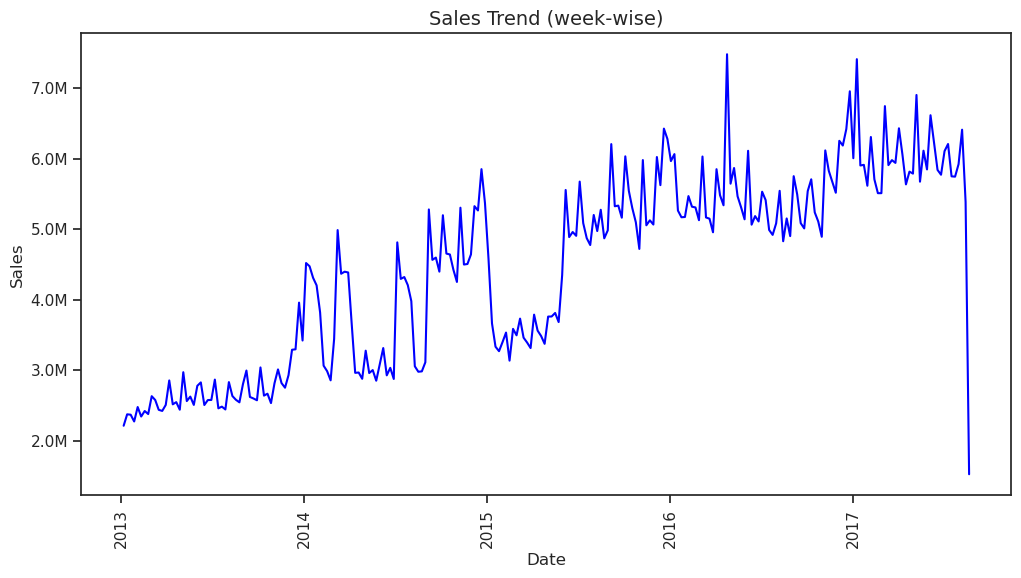

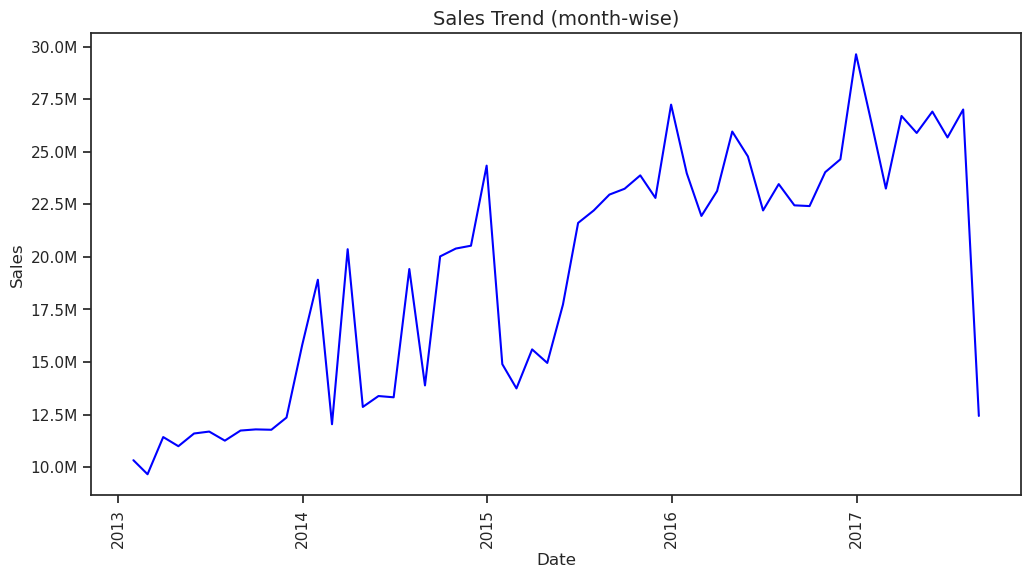

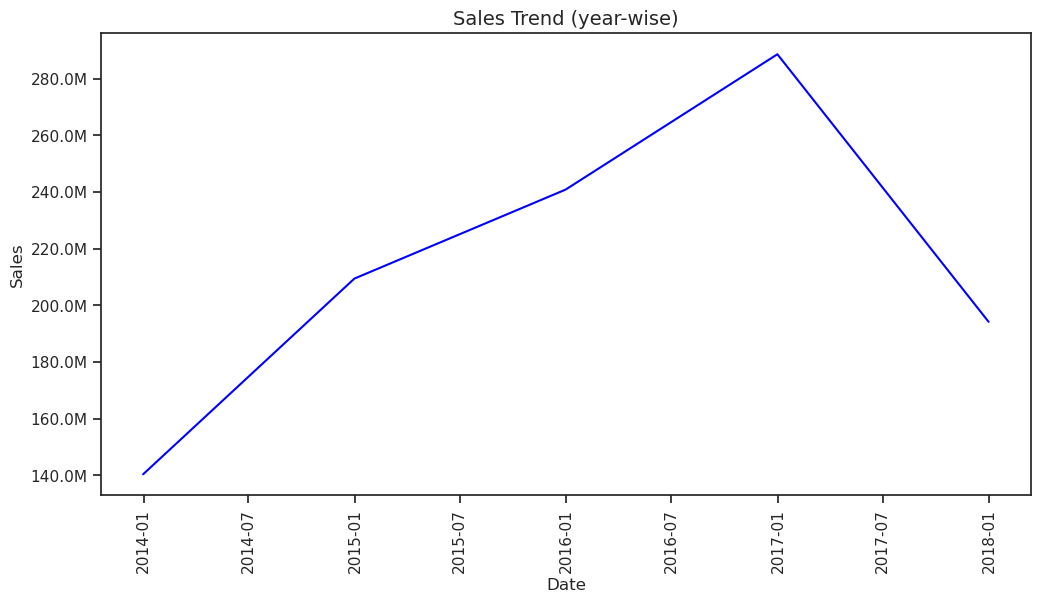

In [63]:
plot_trend(train_indexed, 'sales', 'week', 'Sales')
plot_trend(train_indexed, 'sales', 'month', 'Sales')
plot_trend(train_indexed, 'sales', 'year', 'Sales')

# 10. Seasonality

In [64]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    
    palette = sns.color_palette("husl", n_colors=X[period].nunique())
    sns.lineplot(x=freq, y=y, hue=period, data=X, errorbar=('ci', False), ax=ax, palette=palette, legend=False)
    
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(),
                    xycoords=ax.get_yaxis_transform(), textcoords="offset points",
                    size=14, va="center")
    
    return ax

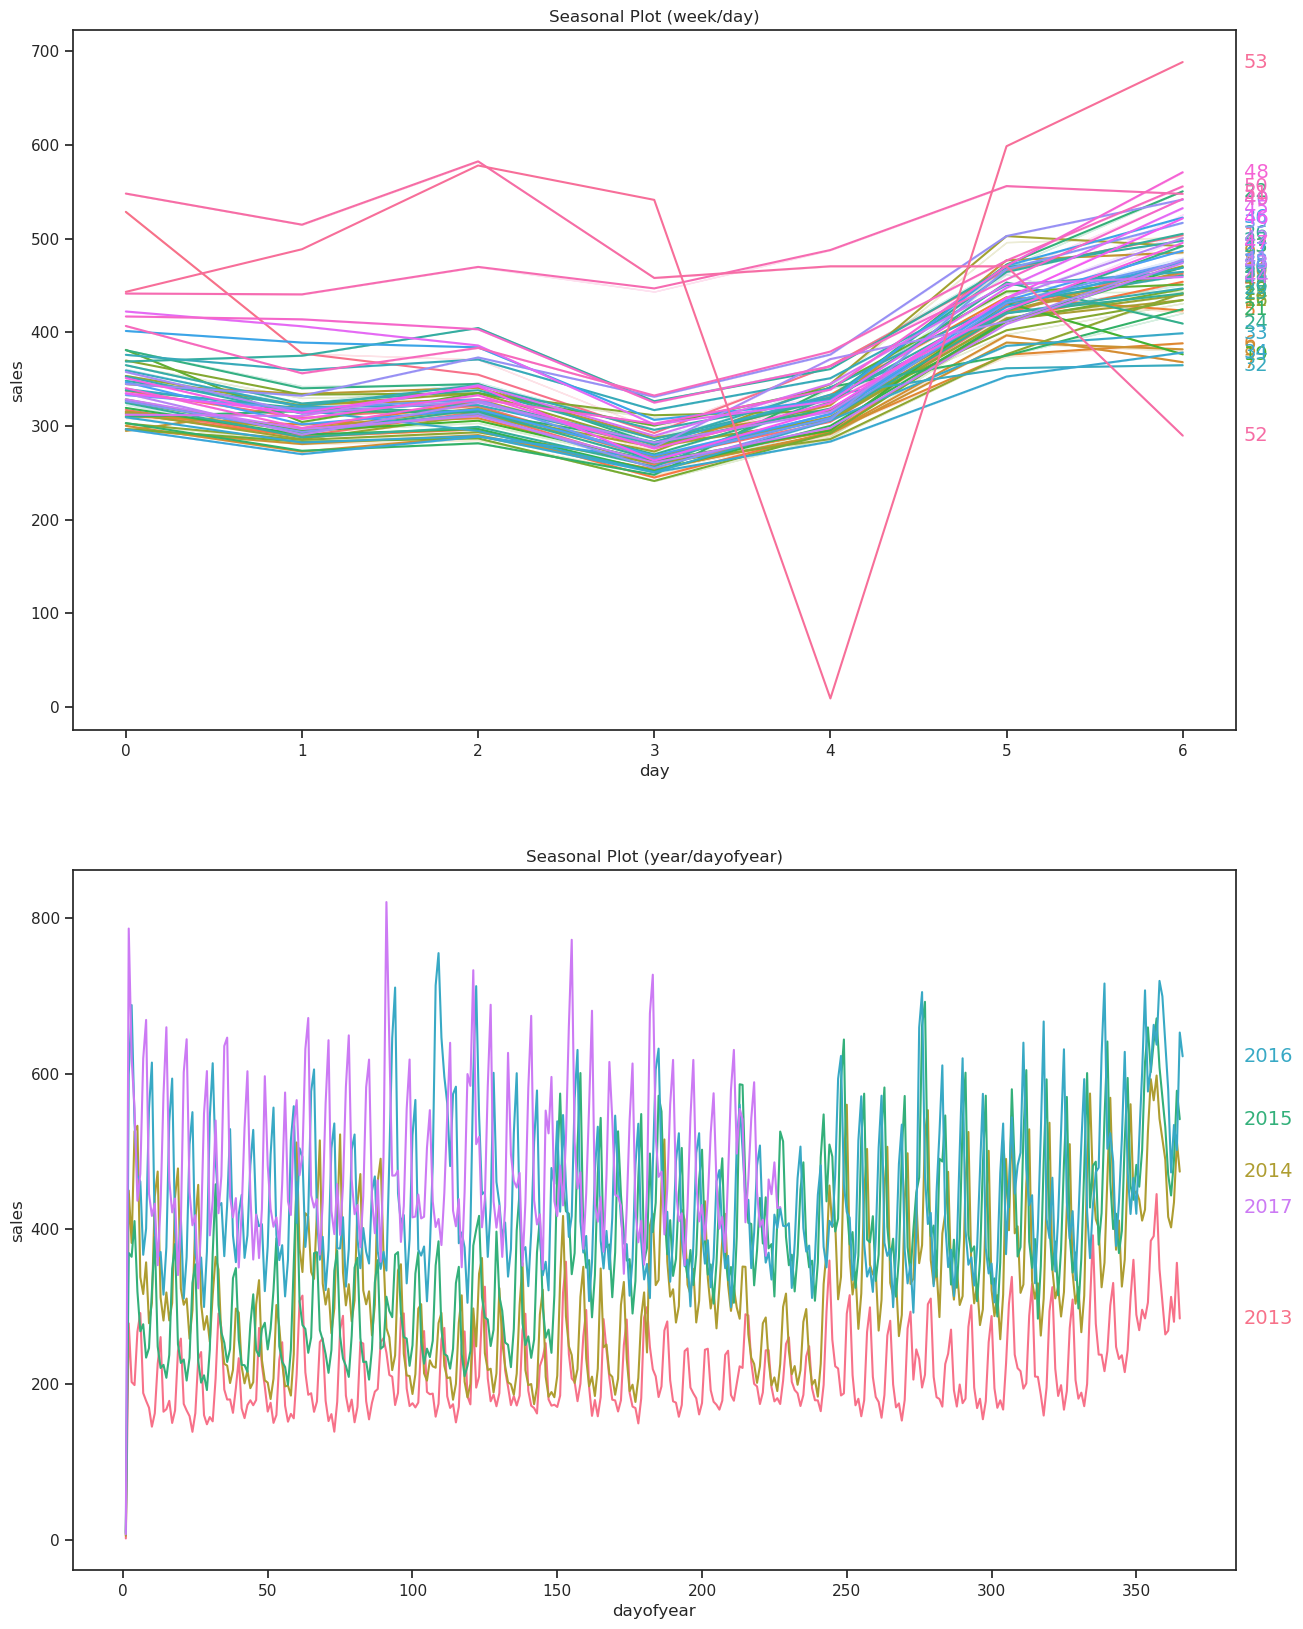

In [65]:
avg_sales_train = train.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales_train = avg_sales_train.set_index('date').to_period("D")

X = avg_sales_train.copy()

# days within a week
X['day'] = X.index.dayofweek # the x-axis (freq)
X['week'] = X.index.week # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 20))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

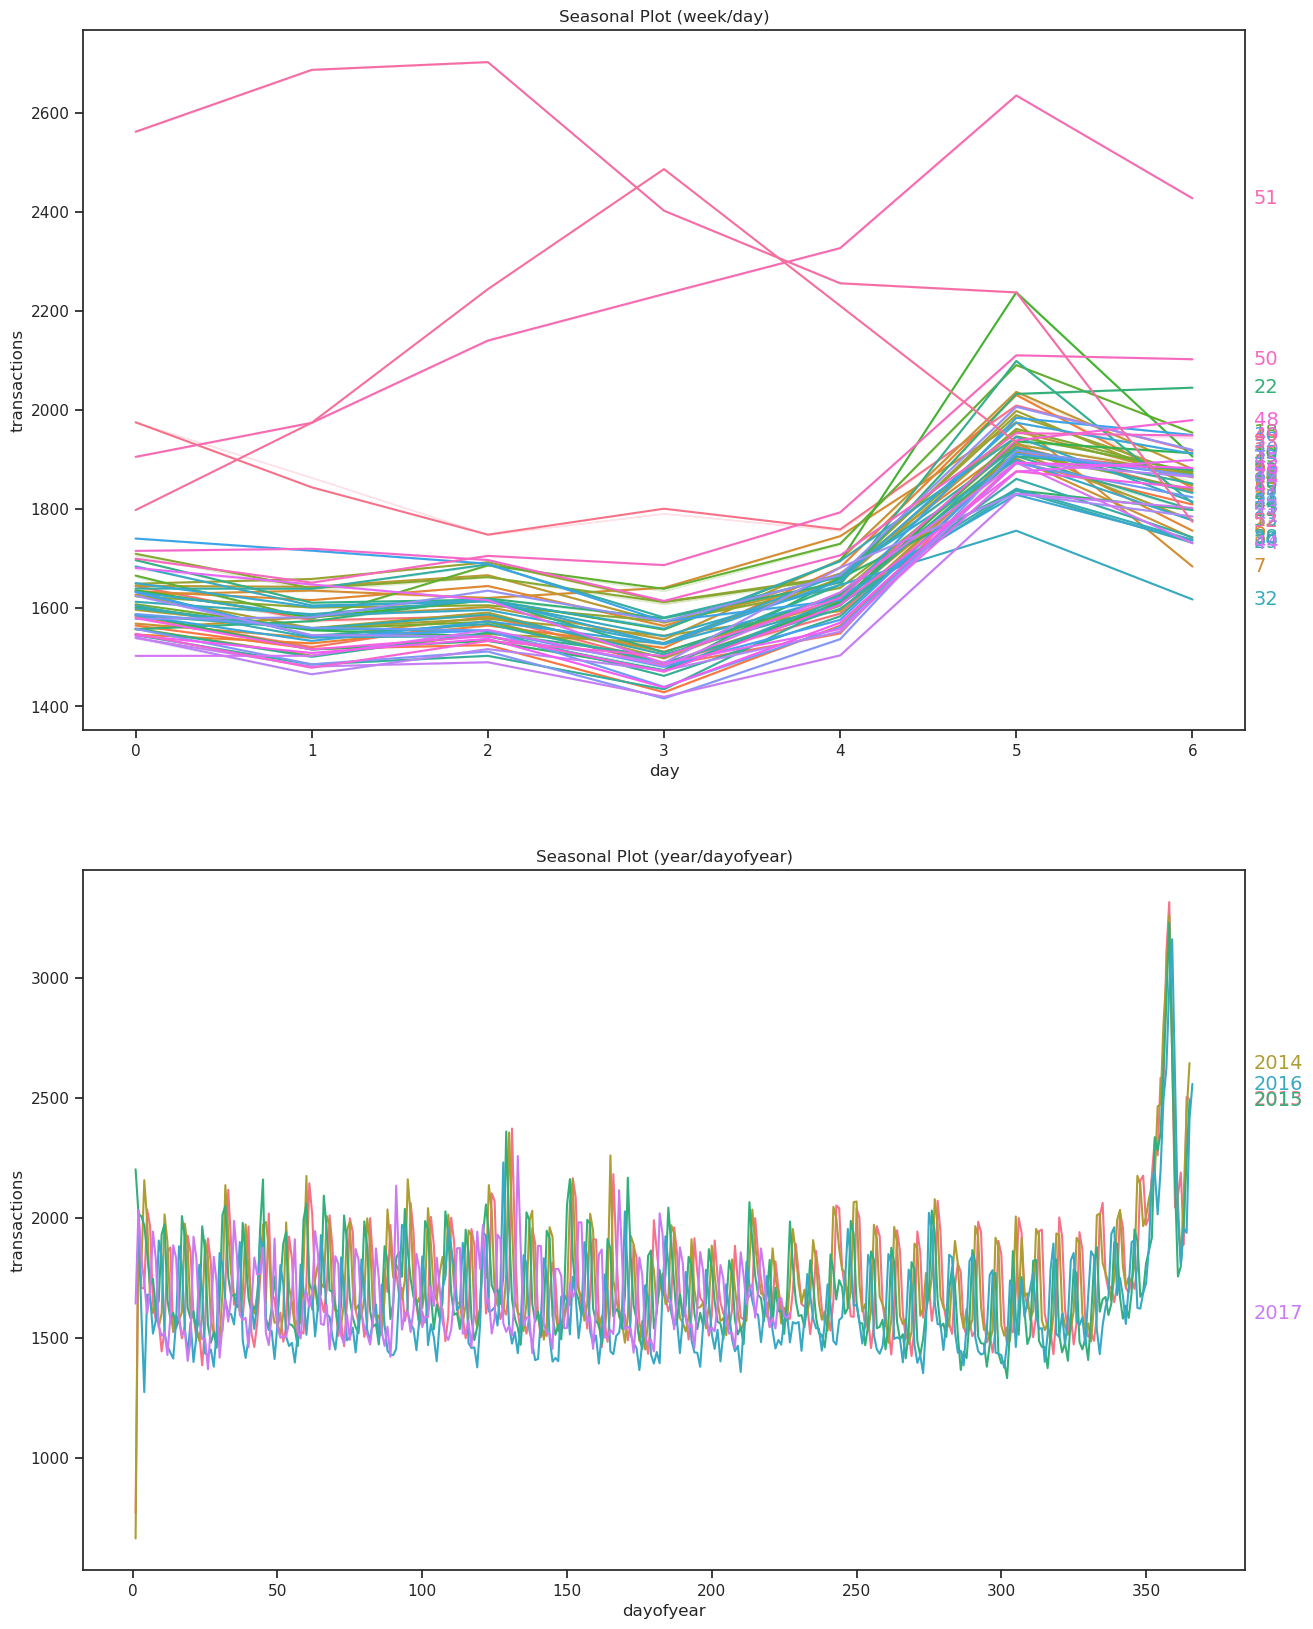

In [66]:
avg_sales_train = transactions.groupby('date').agg({'transactions': 'mean'}).reset_index()
avg_sales_train = avg_sales_train.set_index('date').to_period("D")

X = avg_sales_train.copy()

# days within a week
X['day'] = X.index.dayofweek # the x-axis (freq)
X['week'] = X.index.week # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 20))
seasonal_plot(X, y="transactions", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="transactions", period="year", freq="dayofyear", ax=ax1);

# 11. Did Earthquake affect store sales?

### Comparing average sales by year-month .

In [67]:
train['year_month'] = train['date'].dt.to_period('M').astype(str)

# group by year-month and calculate average sales
avg_sales = train.groupby('year_month')['sales'].mean()

In [68]:
avg_sales

year_month
2013-01    186.952408
2013-02    193.581848
2013-03    206.880585
2013-04    205.639069
2013-05    209.943588
2013-06    218.655899
2013-07    203.783371
2013-08    212.479431
2013-09    220.593582
2013-10    213.164261
2013-11    231.136536
2013-12    295.606384
2014-01    342.341705
2014-02    241.268890
2014-03    368.661224
2014-04    240.577087
2014-05    242.203125
2014-06    249.157471
2014-07    351.578339
2014-08    251.351807
2014-09    374.530792
2014-10    369.213654
2014-11    384.056030
2014-12    455.302185
2015-01    269.666595
2015-02    275.420807
2015-03    282.368622
2015-04    279.743134
2015-05    320.958130
2015-06    404.327728
2015-07    402.042267
2015-08    415.692291
2015-09    434.734039
2015-10    432.248413
2015-11    426.579742
2015-12    509.614319
2016-01    434.050262
2016-02    424.695404
2016-03    418.735413
2016-04    485.653290
2016-05    448.561462
2016-06    415.436188
2016-07    424.725250
2016-08    406.437378
2016-09    419.331238

In [69]:
avg_sales.index = pd.to_datetime(avg_sales.index)

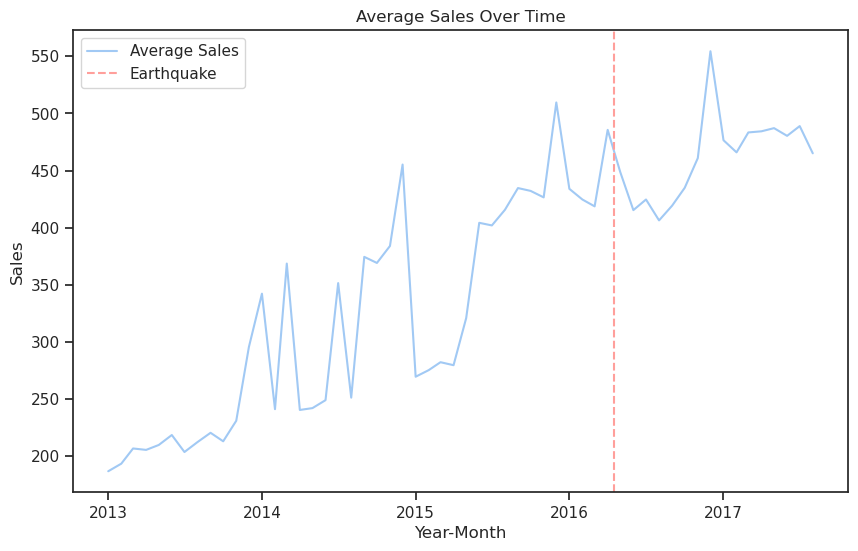

In [70]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(avg_sales.index, avg_sales.values, label='Average Sales')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Sales')
ax.set_title('Average Sales Over Time')

# add a vertical line for the earthquake in April 2016
ax.axvline(pd.to_datetime('2016-04-16'), color='r', linestyle='--', label='Earthquake')
ax.legend()

plt.show()

# 12. Machine Learning Forecasting

In [71]:
# Create separate columns for year, month, day, and week
train['week'] = train['date'].dt.isocalendar().week
train['day'] = train['date'].dt.day

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['week'] = test['date'].dt.isocalendar().week


In [72]:
train = train.drop(['day_of_week','year_month','family_category'],axis=1)
train.head()

id       date  store_nbr      family  sales  onpromotion  month  year  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0          0.0      1  2013   
1   1 2013-01-01          1   BABY CARE    0.0          0.0      1  2013   
2   2 2013-01-01          1      BEAUTY    0.0          0.0      1  2013   
3   3 2013-01-01          1   BEVERAGES    0.0          0.0      1  2013   
4   4 2013-01-01          1       BOOKS    0.0          0.0      1  2013   

   week  day  
0     1    1  
1     1    1  
2     1    1  
3     1    1  
4     1    1

In [73]:
test.head()

id       date  store_nbr      family  onpromotion  year  month  day  \
0  3000888 2017-08-16          1  AUTOMOTIVE            0  2017      8   16   
1  3000889 2017-08-16          1   BABY CARE            0  2017      8   16   
2  3000890 2017-08-16          1      BEAUTY            2  2017      8   16   
3  3000891 2017-08-16          1   BEVERAGES           20  2017      8   16   
4  3000892 2017-08-16          1       BOOKS            0  2017      8   16   

   week  
0    33  
1    33  
2    33  
3    33  
4    33

In [74]:
train['week'] = train['week'].astype('int')
test['week'] = test['week'].astype('int')

## Training and validation data

In [75]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(['id','date', 'sales'], axis=1), 
                                                  train['sales'], 
                                                  test_size=0.3)

In [76]:
cat_variables=['family']
time_variables = ['day', 'month', 'year','week']

ord_encoder=OrdinalEncoder(encoding_method='arbitrary', variables=cat_variables)
cf_encoder = CyclicalFeatures(variables=time_variables)

encoders = make_pipeline(
    (ord_encoder), #Ordinal Encoder
    (cf_encoder), #Cyclical Feature
)

In [77]:
xgb_params = {'n_estimators': 100, 'max_depth': 6, 'eta': 0.1, 'gamma': 2, 'n_jobs': -1, 'random_state': 42, 'eval_metric': 'rmse'}
xgb = XGBRegressor(**xgb_params)

In [78]:
pipeline = make_pipeline(
    (encoders), #Encoders
    (xgb) #XGBoost
)
print("Pipeline Created!")

Pipeline Created!


In [79]:
transformer = TransformedTargetRegressor(regressor=pipeline, func=np.log1p, inverse_func=lambda x: np.exp(x) - 1,check_inverse=False)

In [80]:
# Train the model using 5-fold Time series cross validation. RMSE metric will be used.
tscv = TimeSeriesSplit(n_splits=5, gap=7*54*33)

rmse_values = []
rmsle_values = []

cv = 1
# Loop through the folds
print("Cross Validating.....")

for train_index, test_index in tscv.split(X_train, y_train):
       
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model on the train data
    transformer.fit(X_train_cv, y_train_cv)

    # Predict on the test data
    y_pred = transformer.predict(X_test_cv)
    
    # Calculate the mean squared error
    rmse = mean_squared_error(y_test_cv, y_pred, squared=False)
    rmsle = mean_squared_log_error(y_test_cv, y_pred.clip(0.0), squared=False)
        
    print(f"cv #{cv}: RMSE = {rmse:.3f} | RMSLE = {rmsle:.3f}")
    
    rmse_values.append(rmse)
    rmsle_values.append(rmsle)
    cv += 1

print(f"Average RMSE: {np.mean(rmse_values):.3f} | Average RMSLE: {np.mean(rmsle_values):.3f}")

Cross Validating.....
cv #1: RMSE = 603.071 | RMSLE = 0.937
cv #2: RMSE = 619.481 | RMSLE = 0.946
cv #3: RMSE = 604.021 | RMSLE = 0.938
cv #4: RMSE = 653.763 | RMSLE = 0.942
cv #5: RMSE = 626.050 | RMSLE = 0.961
Average RMSE: 621.277 | Average RMSLE: 0.945


In [81]:
predictions = transformer.predict(X_val)

val_rmse = mean_squared_error(y_val, predictions, squared=False)
val_rmsle = mean_squared_log_error(y_val, predictions.clip(0.0), squared=False)

print(f"Test RMSE Score: {val_rmse:.3f} | Test RMSLE Score: {val_rmsle:.3f}")

Test RMSE Score: 629.572 | Test RMSLE Score: 0.962


In [82]:
val_df = pd.concat([X_val[['store_nbr', 'family']], y_val], axis=1)
val_df['predictions'] = predictions
cut_off_date = "2017-06-15"
val_df['date'] = train.loc[train['date'].ge(cut_off_date), 'date']

val_df['error'] = val_df['sales'] - val_df['predictions']

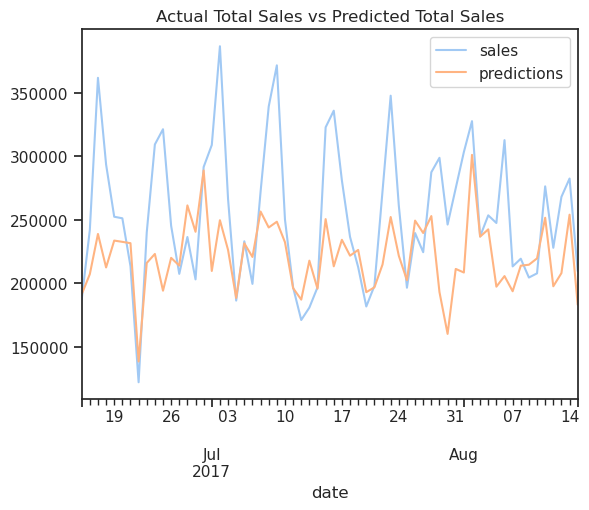

In [83]:
val_df.groupby('date')[['sales', 'predictions']].sum().plot(title='Actual Total Sales vs Predicted Total Sales');

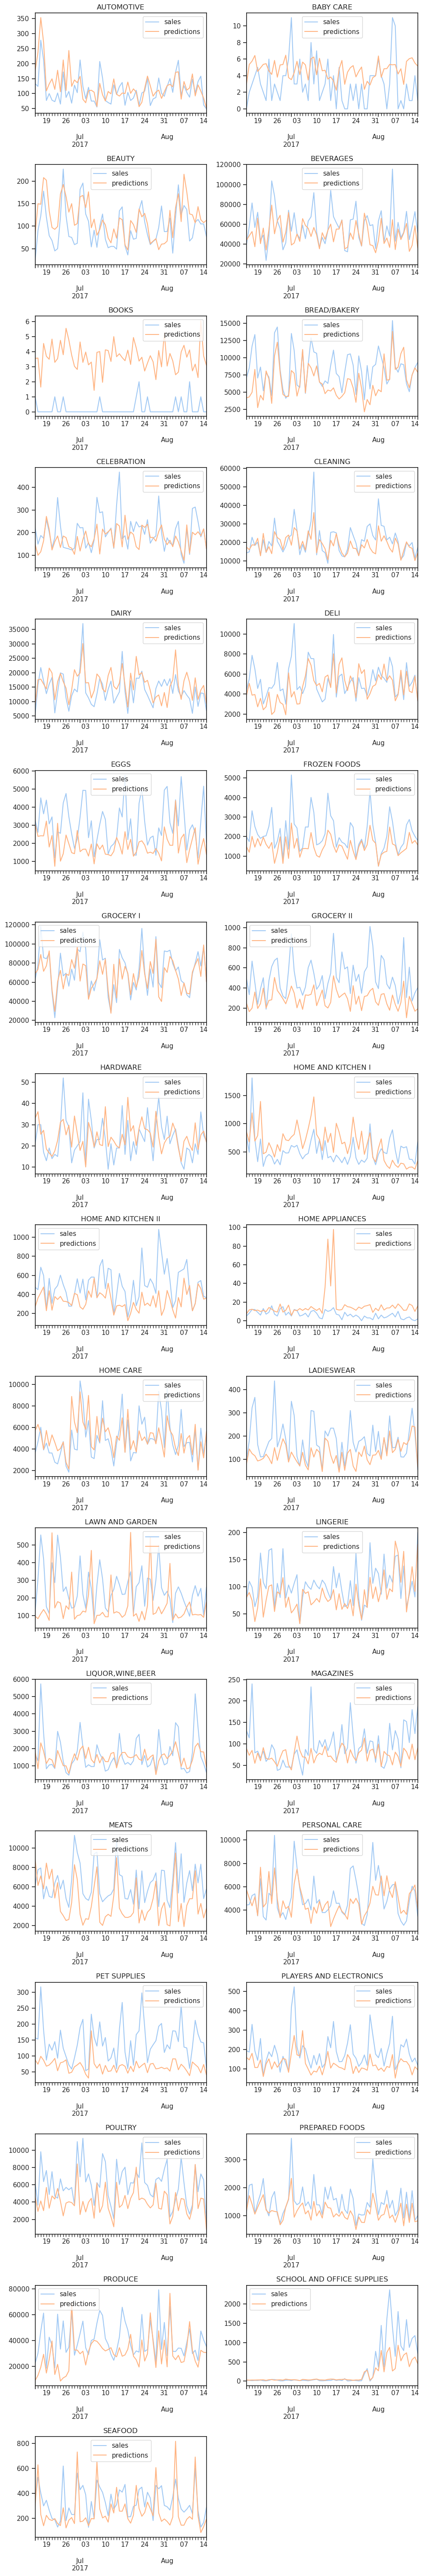

In [84]:
family_agg_val_df = val_df.groupby(['date', 'family'], as_index=False)[['sales', 'predictions']].sum()

fig, axes = plt.subplots(17, 2, tight_layout=True, figsize=(10, 60), squeeze = False)

for prd, ax in zip(family_agg_val_df['family'].unique(), axes.flatten()):
    family_agg_val_df.query(f"family=='{prd}'").plot(x='date', y=['sales', 'predictions'], ax=ax)
    ax.set_title(prd)
    ax.set_xlabel("");
    
axes[-1,-1].set_axis_off()

## Test data predictions and graphs

In [85]:
test.head()

id       date  store_nbr      family  onpromotion  year  month  day  \
0  3000888 2017-08-16          1  AUTOMOTIVE            0  2017      8   16   
1  3000889 2017-08-16          1   BABY CARE            0  2017      8   16   
2  3000890 2017-08-16          1      BEAUTY            2  2017      8   16   
3  3000891 2017-08-16          1   BEVERAGES           20  2017      8   16   
4  3000892 2017-08-16          1       BOOKS            0  2017      8   16   

   week  
0    33  
1    33  
2    33  
3    33  
4    33

In [86]:
new_df = pd.DataFrame({"date": test["date"]})
X_test = test.drop(['id','date'], axis=1)

In [87]:
X_test.head()

store_nbr      family  onpromotion  year  month  day  week
0          1  AUTOMOTIVE            0  2017      8   16    33
1          1   BABY CARE            0  2017      8   16    33
2          1      BEAUTY            2  2017      8   16    33
3          1   BEVERAGES           20  2017      8   16    33
4          1       BOOKS            0  2017      8   16    33

In [88]:
X_test = X_test.reindex(columns=['store_nbr', 'family', 'onpromotion', 'month', 'year', 'week', 'day'])

In [89]:
X_test.head()

store_nbr      family  onpromotion  month  year  week  day
0          1  AUTOMOTIVE            0      8  2017    33   16
1          1   BABY CARE            0      8  2017    33   16
2          1      BEAUTY            2      8  2017    33   16
3          1   BEVERAGES           20      8  2017    33   16
4          1       BOOKS            0      8  2017    33   16

In [90]:
predictions = transformer.predict(X_test)

In [91]:
test_df = pd.DataFrame({
    "store_nbr": X_test["store_nbr"],
    "family": X_test["family"]
})
test_df['predictions'] = predictions
cut_off_date = "2017-06-15"
test_df['date'] = new_df

In [92]:
test_df.head()

store_nbr      family  predictions       date
0          1  AUTOMOTIVE     5.044271 2017-08-16
1          1   BABY CARE     0.240494 2017-08-16
2          1      BEAUTY     5.402296 2017-08-16
3          1   BEVERAGES  2398.989746 2017-08-16
4          1       BOOKS     0.250289 2017-08-16

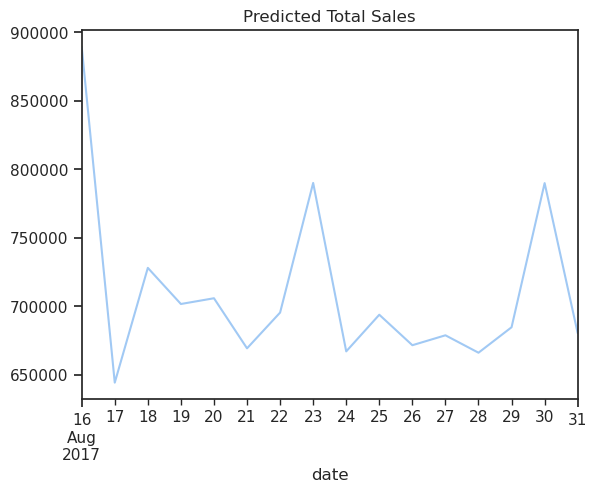

In [93]:
test_df.groupby('date')['predictions'].sum().plot(title='Predicted Total Sales');

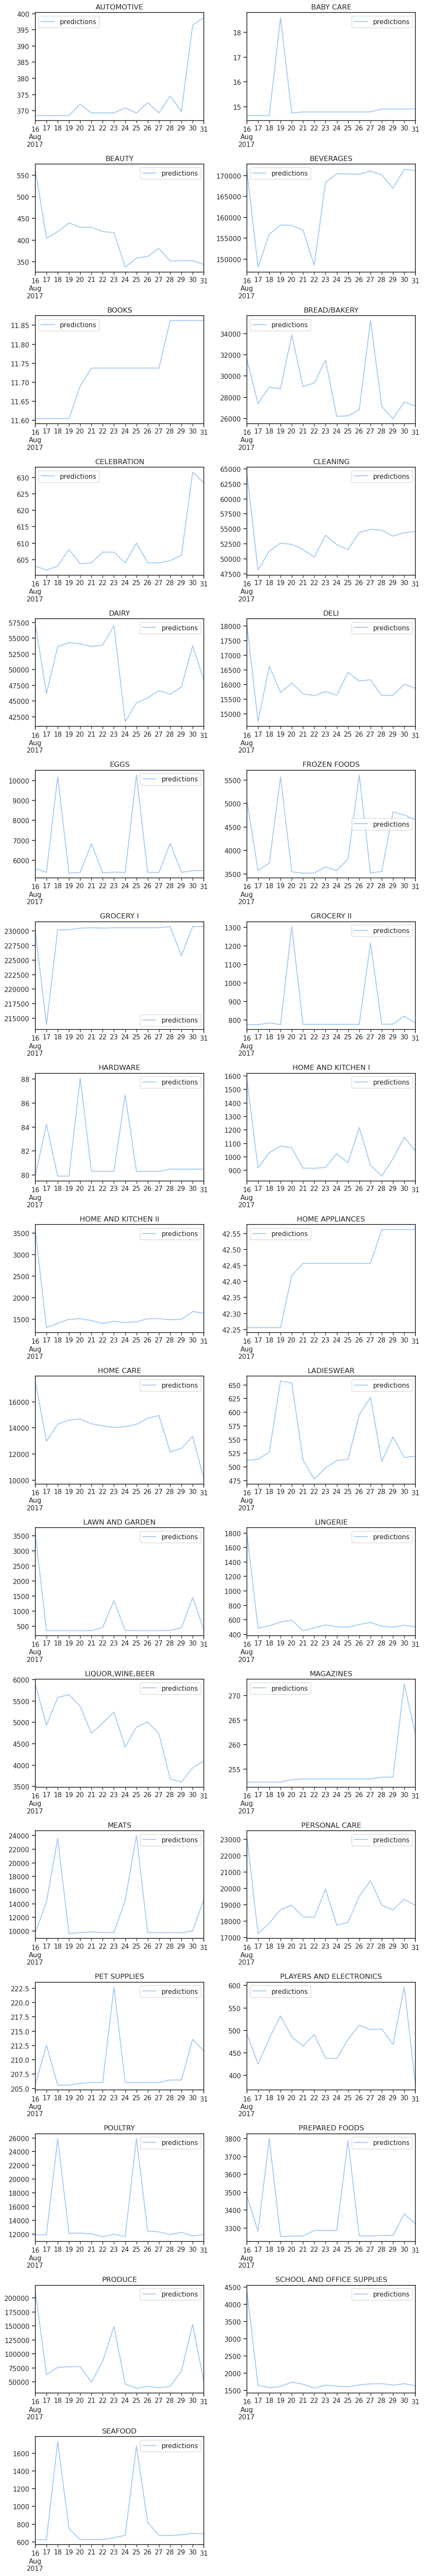

In [94]:
family_agg_test_df = test_df.groupby(['date', 'family'], as_index=False)['predictions'].sum()

fig, axes = plt.subplots(17, 2, tight_layout=True, figsize=(10, 60), squeeze = False)

for prd, ax in zip(family_agg_test_df['family'].unique(), axes.flatten()):
    family_agg_test_df.query(f"family=='{prd}'").plot(x='date', y='predictions', ax=ax)
    ax.set_title(prd)
    ax.set_xlabel("");
    
axes[-1,-1].set_axis_off()

### Submission.csv

In [95]:
output = pd.DataFrame({'id': test.id,
                       'sales': test_df.predictions})
output.to_csv('submission.csv', index=False)

# References

## Thanks to all

### https://www.kaggle.com/code/maricinnamon/store-sales-time-series-forecast-visualization/notebook
### https://www.kaggle.com/code/howoojang/first-kaggle-notebook-following-ts-tutorial/notebook
### https://www.kaggle.com/code/joeanton/detail-eda-oil-price-causal-analysis-xgbpredict/notebook

### IF YOU LIKED THIS ARTICLE ABOUT TIME SERIES, PLEASE, MAKE AN UPVOTE ❤️